In [1]:
import os

from Bio import AlignIO, SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyranges
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import kruskal
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import shapiro


from zhunt_wrapper import alanrun


In [2]:
# Plots stuff
sns.set()
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
pd.options.plotting.backend = "matplotlib"


# Run ZHunt

In [3]:
sequences_df = pd.read_csv('summary.csv')
sequences_df['date'] = pd.to_datetime(sequences_df['date'])
exclude_list = ['sars2003', 'mers']
sequences_df

accession     strain       date acc_date  offset
0    MW883202.1    epsilon 2020-10-15        y      18
1    MW453103.1       zeta 2020-12-24        y      69
2    MW560924.1        eta 2021-01-17        y      50
3    MZ681419.1       iota 2020-12-11        y      18
4    MW598419.1       beta 2021-01-14        y      73
5    MZ275289.1     lambda 2021-01-30        y      24
6    MZ555270.1      theta 2021-06-22        y       0
7    MZ169911.1      gamma 2021-02-19        y      73
8    OD920331.1      alpha 2020-12-11        y      18
9    MZ359841.1      delta 2021-04-22        y      22
10   MZ702637.1      kappa 2021-04-08        y      22
11  NC_045512.2  reference 2019-12-01        y      73
12  NC_004718.3   sars2003 2003-04-14        y       0
13     KU740200       mers 2014-12-17        y       0

In [4]:
alignment = AlignIO.read(open("fasta/12_cov2_strains_aligned.fasta"), "fasta")
aligned_sequences = {seq.name: seq for seq in alignment}
aligned_sequences_df = pd.DataFrame({seq.name: list(seq) for seq in alignment}).T

In [5]:
aligned_sequences_df.head()

0     1     2     3     4     5     6     7     8     9      ...  \
MZ169911.1     A     T     T     A     A     A     G     G     T     T  ...   
MZ555270.1     -     -     -     -     -     -     -     -     -     -  ...   
OD920331.1     -     -     -     -     -     -     -     -     -     -  ...   
MZ359841.1     -     -     -     -     -     -     -     -     -     -  ...   
MZ702637.1     -     -     -     -     -     -     -     -     -     -  ...   

           29893 29894 29895 29896 29897 29898 29899 29900 29901 29902  
MZ169911.1     A     A     A     A     A     A     A     A     A     A  
MZ555270.1     -     -     -     -     -     -     -     -     -     -  
OD920331.1     -     -     -     -     -     -     -     -     -     -  
MZ359841.1     -     -     -     -     -     -     -     -     -     -  
MZ702637.1     -     -     -     -     -     -     -     -     -     -  

[5 rows x 29903 columns]

In [6]:
aligned_sequences_df.index

Index(['MZ169911.1', 'MZ555270.1', 'OD920331.1', 'MZ359841.1', 'MZ702637.1',
       'MZ275289.1', 'MW560924.1', 'MW598419.1', 'MW883202.1', 'MW453103.1',
       'MZ681419.1', 'NC_045512.2'],
      dtype='object')

In [7]:
z_hunt_results = {}
for _, row in sequences_df[['strain', 'offset']].iterrows():
    strain_name, offset = row.loc['strain'], row.loc['offset']
    with open(f'fasta/{strain_name}.fasta', 'r') as tmp_fasta:
        accession = sequences_df.set_index('strain')['accession'].loc[strain_name]
        z_hunt_res = alanrun(''.join(tmp_fasta.readlines()[1:]).replace('\n', ''),)
        if accession in aligned_sequences_df.index:
            z_hunt_res['Start'] = z_hunt_res['Start'].apply(
                lambda old_start: old_start + (aligned_sequences_df.loc[accession].iloc[:old_start]  == '-').sum()
            )
            z_hunt_res['End'] = z_hunt_res['End'].apply(
                lambda old_end: old_end + (aligned_sequences_df.loc[accession].iloc[:old_end]  == '-').sum()
            )
        z_hunt_results[strain_name] = z_hunt_res

dinucleotides 8
min/max 6 8
min/max 6 8
operating on /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmptaxl6cyx
calculating zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmptaxl6cyx
inputting sequence
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmptaxl6cyx.Z-SCORE

 run time=0 sec
use min/max 6 8
analyzing_zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmptaxl6cyx.Z-SCORE
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmptaxl6cyx
inputting sequence
dinucleotides 8
min/max 6 8
min/max 6 8
operating on /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp7dhexnxr
calculating zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp7dhexnxr
inputting sequence
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp7dhexnxr.Z-SCORE

 run time=1 sec
use min/max 6 8
analyzing_zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp7dhexnxr.Z-SCORE
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp7d

In [684]:
z_hunt_results['reference']

Start    End  nu-1    nu-2    nu-3   Z-Score          Sequence  \
0          1     17    16  32.059  26.188  0.188233  attaaaggtttatacc   
1          2     18    16  30.200  28.375  0.420383  ttaaaggtttatacct   
2          3     17    14  31.703  27.287  0.225544    taaaggtttatacc   
3          4     18    14  29.878  30.366  0.467151    aaaggtttatacct   
4          5     17    12  31.481  28.602  0.250816      aaggtttatacc   
...      ...    ...   ...     ...     ...       ...               ...   
29898  29899  29913    14  34.855   9.251  0.027928    aaaaaattaaaggt   
29899  29900  29916    16  35.148  20.032  0.021698  aaaaattaaaggttta   
29900  29901  29917    16  33.649  15.281  0.070950  aaaattaaaggtttat   
29901  29902  29918    16  33.586  24.518  0.074107  aaattaaaggtttata   
29902  29903  29919    16  30.707  25.796  0.349235  aattaaaggtttatac   

           Conformation  
0      ASASASASASASASAS  
1      SASASASASASASASA  
2        ASASASASASASAS  
3        SASASASASASASA  
4          ASASASASASAS  
...                 ...  
29898    SASASASASASASA  
29899  ASASASASASASASAS  
29900  SASASASASASASASA  
29901  ASASASASASASASAS  
29902  SASASASASASASASA  

[29903 rows x 8 columns]

In [685]:
analysis_df = sequences_df.copy()
analysis_df['mean_zscore'] = analysis_df['strain'].map(lambda strain: z_hunt_results[strain]['Z-Score'].mean())
analysis_df['median_zscore'] = analysis_df['strain'].map(lambda strain: z_hunt_results[strain]['Z-Score'].median())
analysis_df

accession     strain       date acc_date  offset  mean_zscore  \
0    MW883202.1    epsilon 2020-10-15        y      18     6.098604   
1    MW453103.1       zeta 2020-12-24        y      69     6.077690   
2    MW560924.1        eta 2021-01-17        y      50     6.087384   
3    MZ681419.1       iota 2020-12-11        y      18     6.105467   
4    MW598419.1       beta 2021-01-14        y      73     6.049067   
5    MZ275289.1     lambda 2021-01-30        y      24     6.097063   
6    MZ555270.1      theta 2021-06-22        y       0     6.118544   
7    MZ169911.1      gamma 2021-02-19        y      73     6.081765   
8    OD920331.1      alpha 2020-12-11        y      18     6.121260   
9    MZ359841.1      delta 2021-04-22        y      22     6.100821   
10   MZ702637.1      kappa 2021-04-08        y      22     6.112090   
11  NC_045512.2  reference 2019-12-01        y      73     6.086225   
12  NC_004718.3   sars2003 2003-04-14        y       0    73.605367   
13     KU740200       mers 2014-12-17        y       0     5.169728   

    median_zscore  
0        0.385565  
1        0.383550  
2        0.384879  
3        0.384793  
4        0.383421  
5        0.385307  
6        0.384407  
7        0.385136  
8        0.384621  
9        0.384793  
10       0.386509  
11       0.384450  
12       0.436941  
13       0.449524

In [686]:
analysis_df = analysis_df[analysis_df['strain']!='sars2003']

# Plot Mean & Median scores

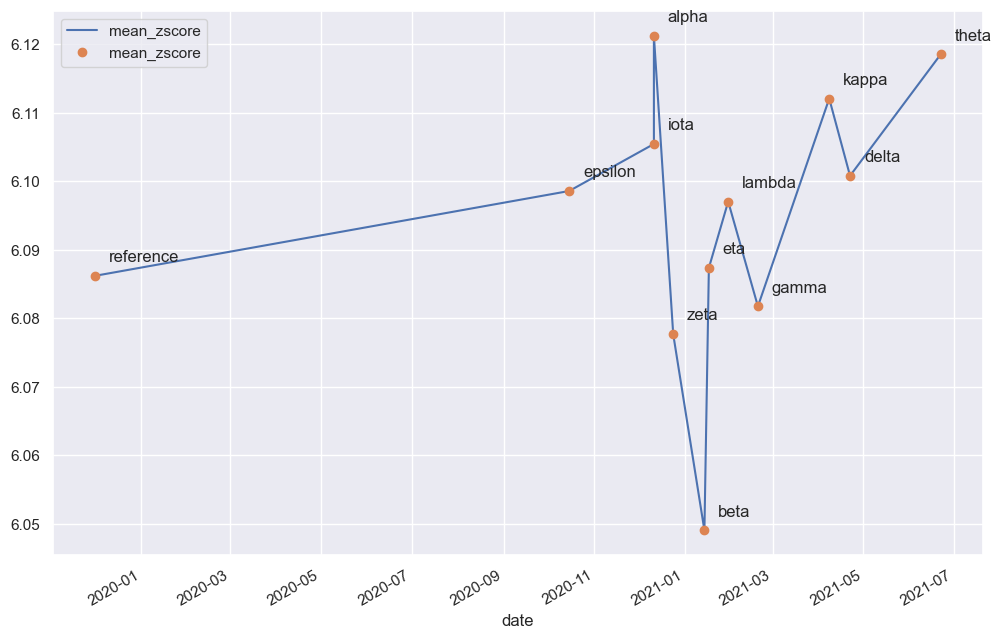

In [482]:
METRIC = 'mean_zscore'

ax = analysis_df.plot(x='date', y=METRIC,)
analysis_df.plot(ax=ax, x='date', y=METRIC, style='o')
for index, (_, row) in enumerate(analysis_df.iterrows()):
    ax.annotate(row.strain, (row.date, row[METRIC]), xytext=(10,10), textcoords='offset points')

plt.show()

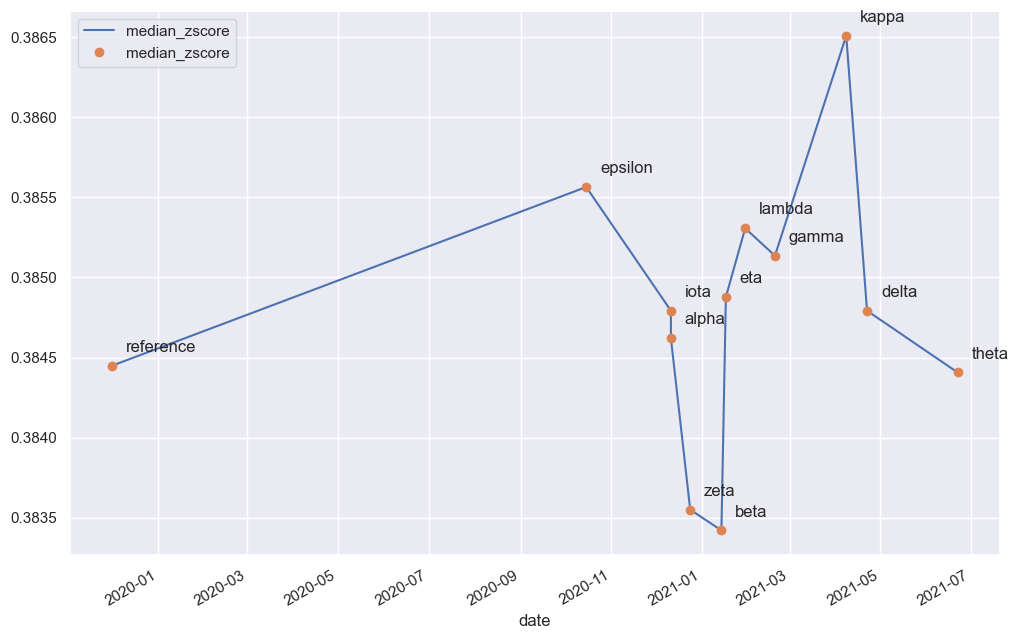

In [483]:
METRIC = 'median_zscore'

ax = analysis_df.plot(x='date', y=METRIC,)
analysis_df.plot(ax=ax, x='date', y=METRIC, style='o')
for index, (_, row) in enumerate(analysis_df.iterrows()):
    ax.annotate(row.strain, (row.date, row[METRIC]), xytext=(10,10), textcoords='offset points')

plt.show()

# Split Zscores by bins:

In [24]:
def get_bins_borders(bin_size, seq_size):
    return np.arange(0, seq_size + bin_size - 1, bin_size / 2, dtype=int,)  # Include right border

In [688]:
bin_borders_r = get_bins_borders(100, 31000)
bin_ranges = list(zip(bin_borders_r[:-2], bin_borders_r[2:]))
def process_sequence_zscores(strain, zscores_df, bin_ranges):
    bins_stats = []
    
    tmp_df = zscores_df.copy()
    tmp_df['Chromosome'] = 0
    ranges = pyranges.PyRanges(tmp_df)
    
    for range_ in bin_ranges:
        intersections_df = ranges.intersect(
            pyranges.PyRanges(
                starts=[range_[0]], ends=[range_[1]], chromosomes=[0]
            )  # Chromosomes param added as a workaround for non-chromosome data
        ).df
        if intersections_df.empty:
            bins_stats.append(
                dict(
                    strain=strain,
                    Start=range_[0],
                    End=range_[1],
                    mean=0,
                    median=0,
                    count=0,
                    scores_sum=0,
                    scores=[],
                )
            )
            continue
        bins_stats.append(
            dict(
                strain=strain,
                Start=range_[0],
                End=range_[1],
                mean=intersections_df['Z-Score'].mean(),
                median=intersections_df['Z-Score'].median(),
                count=intersections_df.shape[0],
                scores_sum=intersections_df['Z-Score'].sum(),
                scores=intersections_df['Z-Score'].tolist(),
            )
        )
    result_df = pd.DataFrame(bins_stats)
    return result_df
    

In [689]:

bins_stats = []
for strain, zscore_df in z_hunt_results.items():
    bins_stats.append(process_sequence_zscores(strain, zscore_df, bin_ranges))
#     if strain != 'sars2003':
#         bins_stats.append(process_sequence_zscores(strain, zscore_df, bin_ranges))
res_df = pd.concat(bins_stats)
res_df


strain  Start    End       mean    median  count   scores_sum  \
0    epsilon      0    100   6.250954  3.281693     49   306.296761   
1    epsilon     50    150  18.401061  3.787607     82  1508.887033   
2    epsilon    100    200  14.940753  3.853314    110  1643.482856   
3    epsilon    150    250   6.423407  4.019291    113   725.844969   
4    epsilon    200    300   9.035933  3.333079    111  1002.988517   
..       ...    ...    ...        ...       ...    ...          ...   
615     mers  30750  30850   0.000000  0.000000      0     0.000000   
616     mers  30800  30900   0.000000  0.000000      0     0.000000   
617     mers  30850  30950   0.000000  0.000000      0     0.000000   
618     mers  30900  31000   0.000000  0.000000      0     0.000000   
619     mers  30950  31050   0.000000  0.000000      0     0.000000   

                                                scores  
0    [0.3911543, 0.1587119, 0.2446429, 0.104716, 0....  
1    [0.4357926, 0.1078441, 0.4174021, 0.08240212, ...  
2    [3.040941, 2.989128, 6.987917, 3.855474, 18.87...  
3    [0.02246622, 0.0619307, 0.05648409, 0.09308421...  
4    [2.964472, 2.806661, 3.317533, 2.521083, 3.567...  
..                                                 ...  
615                                                 []  
616                                                 []  
617                                                 []  
618                                                 []  
619                                                 []  

[8680 rows x 8 columns]

In [690]:
bin_borders_r = get_bins_borders(50, 31000)
bin_ranges = list(zip(bin_borders_r[:-2], bin_borders_r[2:]))

bins_stats = []
for strain, zscore_df in z_hunt_results.items():
    if strain == 'reference':
        bins_stats.append(process_sequence_zscores(strain, zscore_df, bin_ranges))
reference_50_df = pd.concat(bins_stats)
reference_50_df

strain  Start    End       mean    median  count   scores_sum  \
0     reference      0     50   0.717203  0.271009     49    35.142964   
1     reference     25     75   0.679954  0.271009     65    44.197030   
2     reference     50    100   4.113278  0.495313     63   259.136506   
3     reference     75    125  23.900413  8.941667     63  1505.726039   
4     reference    100    150  22.934790  3.191445     61  1399.022204   
...         ...    ...    ...        ...       ...    ...          ...   
1235  reference  30875  30925   0.000000  0.000000      0     0.000000   
1236  reference  30900  30950   0.000000  0.000000      0     0.000000   
1237  reference  30925  30975   0.000000  0.000000      0     0.000000   
1238  reference  30950  31000   0.000000  0.000000      0     0.000000   
1239  reference  30975  31025   0.000000  0.000000      0     0.000000   

                                                 scores  
0     [0.1882331, 0.4203827, 0.2255438, 0.4671511, 0...  
1     [2.270838, 2.865646, 2.41465, 2.88691, 2.07449...  
2     [0.02398209, 0.06292327, 0.07439108, 0.1926848...  
3     [0.3209553, 0.3904651, 0.451745, 0.2575059, 0....  
4     [0.3851358, 3.040941, 2.989128, 6.987917, 3.85...  
...                                                 ...  
1235                                                 []  
1236                                                 []  
1237                                                 []  
1238                                                 []  
1239                                                 []  

[1240 rows x 8 columns]

In [691]:
for strain, df in z_hunt_results.items():
    df['strain'] = strain


combined_scores = []
for strain, _df in z_hunt_results.items():
    df = _df.copy()
    df['strain'] = strain
    combined_scores.append(df)

combined_scores_df = combined_scores_df[combined_scores_df['strain']!='sars2003']
combined_scores_df = pd.concat(combined_scores)


In [ ]:
bin_borders_r = get_bins_borders(100, 31000)
bin_ranges = list(zip(bin_borders_r[:-2], bin_borders_r[2:]))
def get_zscores_by_ranges(combined_scores_df, bin_ranges):
    bins_stats = []
    
    tmp_df = combined_scores_df.copy()
    tmp_df['Chromosome'] = 0
    ranges = pyranges.PyRanges(tmp_df)
    
    for range_ in bin_ranges:
        intersections_df = ranges.intersect(
            pyranges.PyRanges(
                starts=[range_[0]], ends=[range_[1]], chromosomes=[0]
            )  # Chromosomes param added as a workaround for non-chromosome data
        ).df
        intersections_df['Bin_Start'] = range_[0]
        intersections_df['Bin_End'] = range_[1]
        if not intersections_df.empty and len(intersections_df['strain'].unique()) > 1:
            statistic, pval = kruskal(*intersections_df.groupby('strain')['Z-Score'].apply(list))
            intersections_df['Bin_Start'] = range_[0]
            intersections_df['Bin_End'] = range_[1]
            bins_stats.append({
                'Start': range_[0],
                'End': range_[1],
                'pval': pval,
                'statistic': statistic,
            })
        else:
            bins_stats.append({
                'Start': range_[0],
                'End': range_[1],
                'pval': 1,
                'statistic': 0,
            })
    result_df = pd.DataFrame(bins_stats)
    return result_df


stats_df = get_zscores_by_ranges(combined_scores_df, bin_ranges)
stats_df['P_val_adjusted'] = fdrcorrection(stats_df.pval)[1]
stats_df

In [660]:
stats_df[stats_df['P_val_adjusted']<=0.05]

Start    End          pval   statistic  P_val_adjusted
0        0    100  7.438376e-18  109.522201    2.882371e-16
20    1000   1100  3.162098e-03   29.640454    1.195427e-02
21    1050   1150  7.579790e-03   27.058076    2.764394e-02
22    1100   1200  5.663094e-05   40.623570    3.163169e-04
27    1350   1450  2.768818e-09   64.963621    3.011696e-08
..     ...    ...           ...         ...             ...
593  29650  29750  1.119375e-06   50.547291    7.977154e-06
594  29700  29800  4.282787e-18  110.734250    1.770218e-16
595  29750  29850  9.947237e-06   45.089551    6.229583e-05
596  29800  29900  1.497459e-12   79.967169    2.578958e-11
597  29850  29950  5.384875e-13   72.166664    1.011704e-11

[183 rows x 5 columns]

/var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/ipykernel_89531/1493434038.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



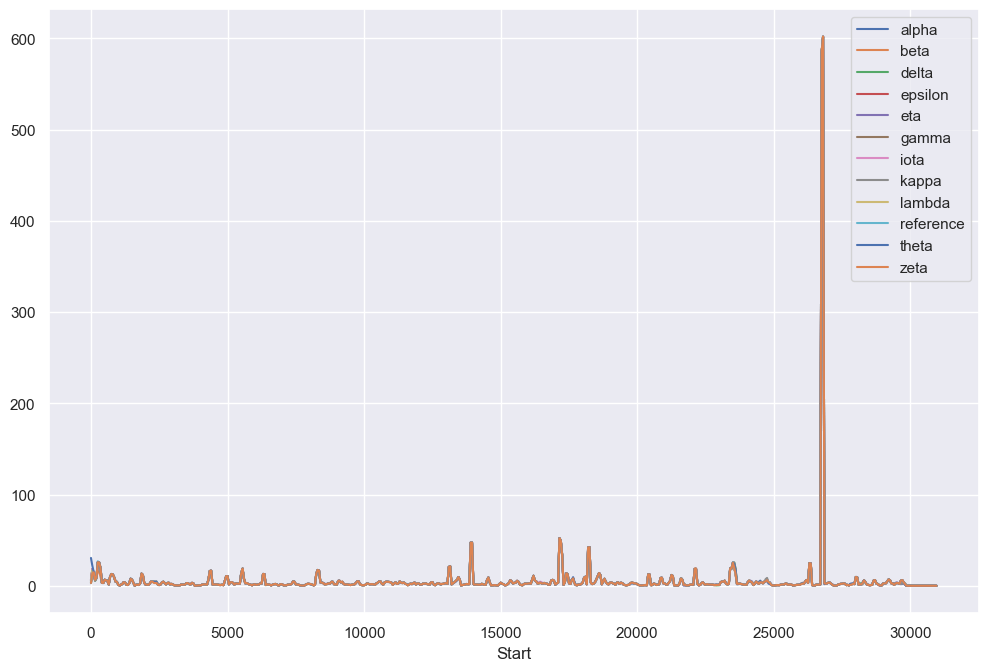

In [490]:
METRIC = 'mean'
fig, ax = plt.subplots()

for name, group in res_df.groupby('strain'):
    group.plot(ax=ax, x='Start', y=METRIC, label=name)

fig.show()

/var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/ipykernel_89531/39688494.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



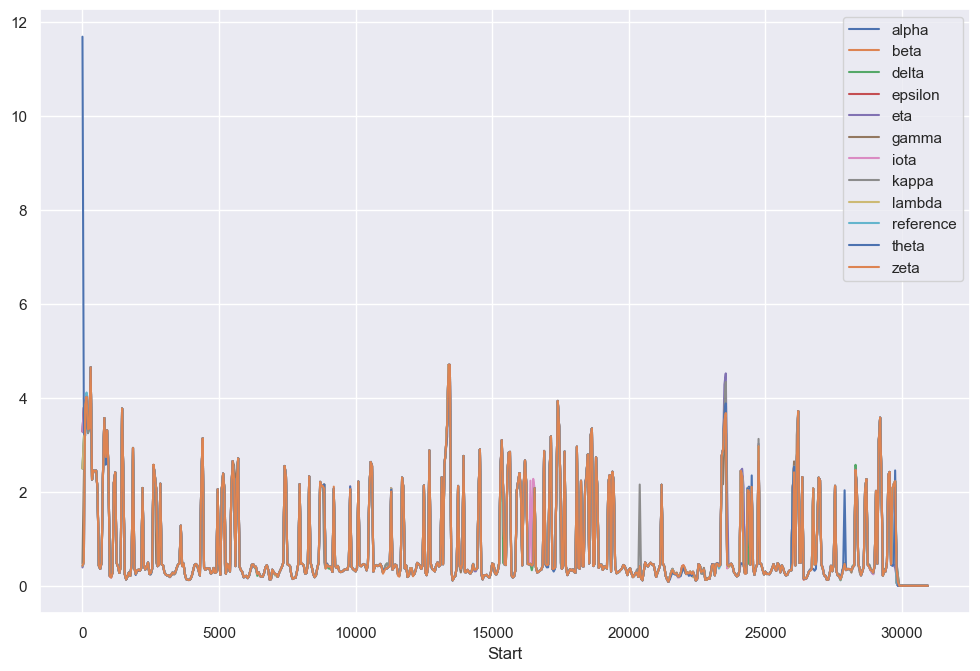

In [491]:
METRIC = 'median'

fig, ax = plt.subplots()

for name, group in res_df.groupby('strain'):
    group.plot(ax=ax, x='Start', y=METRIC, label=name)

fig.show()

/var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/ipykernel_89531/1214877061.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



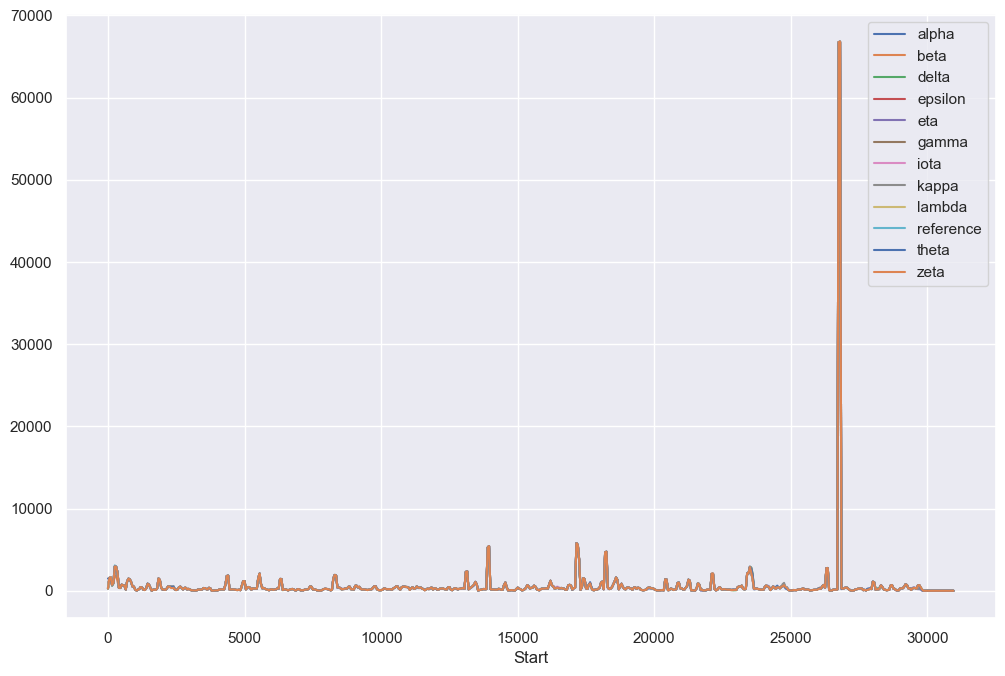

In [492]:
METRIC = 'scores_sum'

fig, ax = plt.subplots()

for name, group in res_df.groupby('strain'):
    group.plot(ax=ax, x='Start', y=METRIC, label=name)

fig.show()

/var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/ipykernel_89531/339707134.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



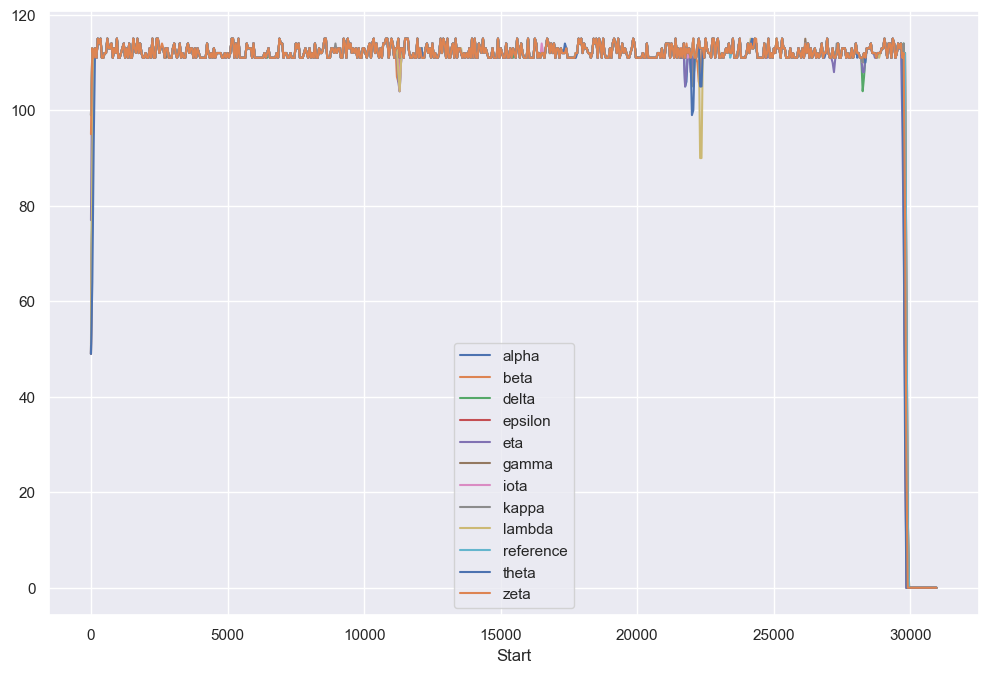

In [493]:
METRIC = 'count'

fig, ax = plt.subplots()

for name, group in res_df.groupby('strain'):
    group.plot(ax=ax, x='Start', y=METRIC, label=name)

fig.show()

## Plotly plots

In [494]:
# bin_borders_r = get_bins_borders(1000, 31000)
# bin_ranges_lr = list(zip(bin_borders_r[:-2], bin_borders_r[2:]))

# bins_stats = []
# for strain, zscore_df in z_hunt_results.items():
#     bins_stats.append(process_sequence_zscores(strain, zscore_df, bin_ranges_lr))
# res_lr_df = pd.concat(bins_stats)
# res_lr_df

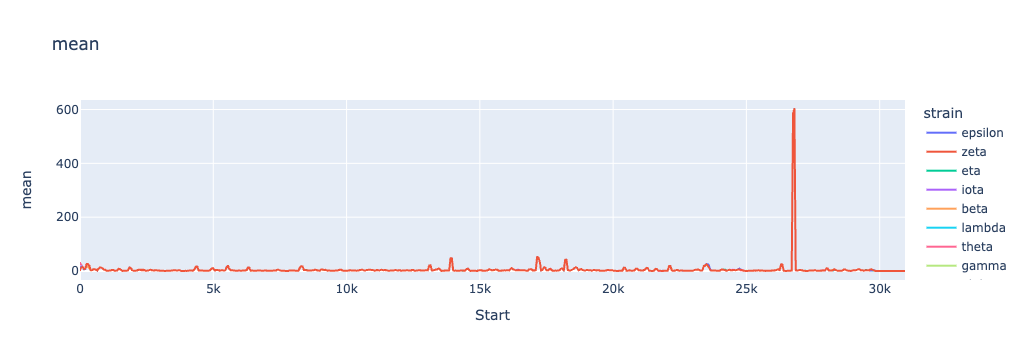

In [517]:
METRIC = 'mean'

fig = px.line(res_df, x="Start", y=METRIC, color='strain', title=METRIC)
max_score = res_df[METRIC].max()
# for _, row in stats_df[stats_df['P_val_adjusted']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="Blue",
#     opacity=0.4,
# )
# for _, row in stats_df[stats_df['pval']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="LightSkyBlue",
#     opacity=0.4,
# )

fig.show()

fig.write_html("./mean_zscores.html")

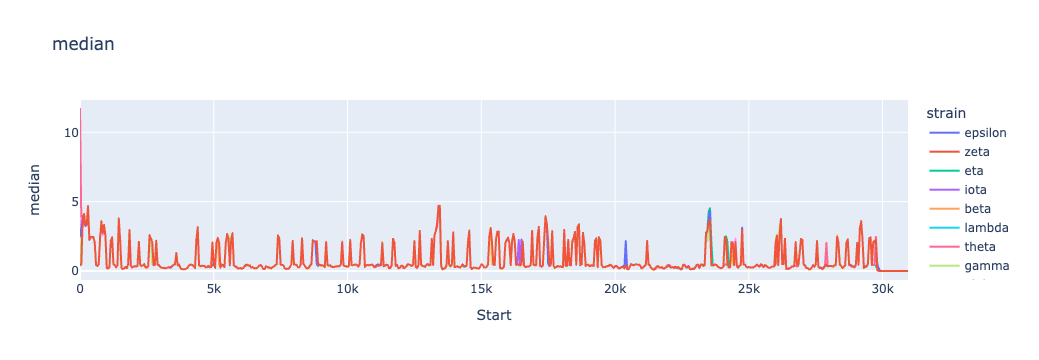

In [496]:
METRIC = 'median'

fig = px.line(res_df, x="Start", y=METRIC, color='strain', title=METRIC)
max_score = res_df[METRIC].max()
# for _, row in stats_df[stats_df['P_val_adjusted']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="Blue",
#     opacity=0.4,
# )
# for _, row in stats_df[stats_df['pval']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="LightSkyBlue",
#     opacity=0.4,
# )

fig.show()

fig.write_html("./median_zscores.html")

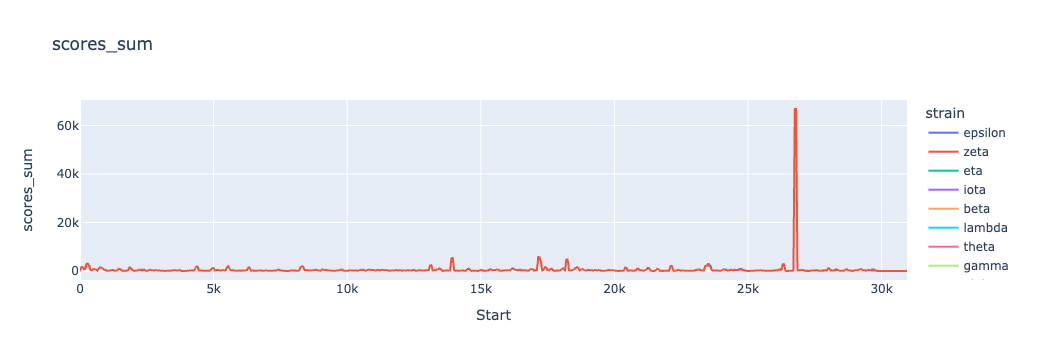

In [497]:
METRIC = 'scores_sum'

fig = px.line(res_df, x="Start", y=METRIC, color='strain', title=METRIC)
max_score = res_df[METRIC].max()
# for _, row in stats_df[stats_df['P_val_adjusted']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="Blue",
#     opacity=0.4,
# )
# for _, row in stats_df[stats_df['pval']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="LightSkyBlue",
#     opacity=0.4,
# )

fig.show()

fig.write_html("./zscores_sum.html")

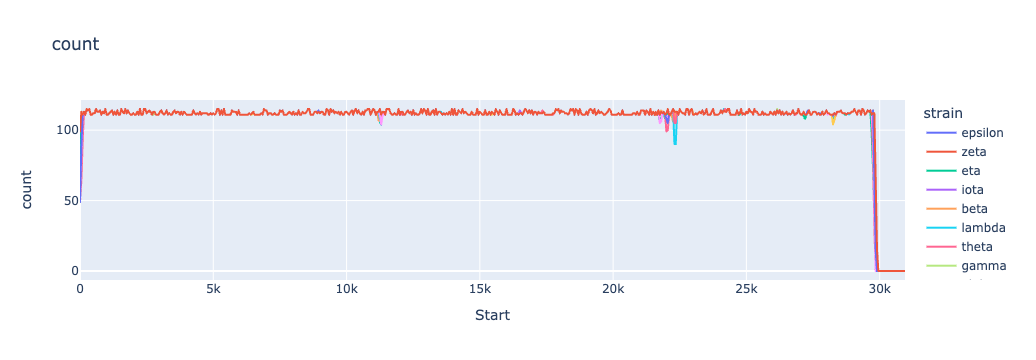

In [498]:
METRIC = 'count'

fig = px.line(res_df, x="Start", y=METRIC, color='strain', title=METRIC)
max_score = res_df[METRIC].max()
# for _, row in stats_df[stats_df['P_val_adjusted']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="Blue",
#     opacity=0.4,
# )
# for _, row in stats_df[stats_df['pval']<=0.05].iterrows():
#     fig.add_shape(type="rect",
#     x0=row.Start, y0=-0.05, x1=row.End, y1=max_score,
#     line=dict(
#         color=None,
#         width=0,
#     ),
#     fillcolor="LightSkyBlue",
#     opacity=0.4,
# )

fig.show()

# Mutations locations analysis

In [429]:
REFERENCE_SEQUENE = sequences_df.set_index('strain').loc['reference'].accession
REFERENCE_SEQUENE

'NC_045512.2'

In [430]:
START_POS = min([col for col in aligned_sequences_df.columns[:100] if (aligned_sequences_df[col] != '-').all()])
END_POS = max([col for col in aligned_sequences_df.columns[29000:] if (aligned_sequences_df[col] != '-').all()])

START_POS, END_POS

(72, 29818)

In [431]:
WINDOW = 10
diff_records = []
for position in range(START_POS, END_POS):
    for strain_acc in aligned_sequences_df.index:
        if aligned_sequences_df.loc[strain_acc, position] != aligned_sequences_df.loc[REFERENCE_SEQUENE, position]:
            old_seq = aligned_sequences_df.loc[REFERENCE_SEQUENE, position-WINDOW: position+WINDOW]
            new_seq = aligned_sequences_df.loc[strain_acc, position-WINDOW: position+WINDOW]
            old_zscores = alanrun(''.join(old_seq))
            new_zscores = alanrun(''.join(new_seq))
            old_mean_score = old_zscores['Z-Score'].mean()
            new_mean_score = new_zscores['Z-Score'].mean()
            old_median_score = old_zscores['Z-Score'].median()
            new_median_score = new_zscores['Z-Score'].median()
            
            statistic, pval = kruskal(old_zscores['Z-Score'], new_zscores['Z-Score'])
    
            strain = sequences_df.set_index('accession')['strain'][strain_acc]
            diff_records.append({
                'position': position,
                'position_plot': (position//100)*100,
                'ref_strain': REFERENCE_SEQUENE,
                'strain_acc': strain_acc,
                'strain': strain,
                'ref_base': aligned_sequences_df.loc[REFERENCE_SEQUENE, position],
                'new_base': aligned_sequences_df.loc[strain_acc, position],
                'old_mean_score': old_mean_score,
                'new_mean_score': new_mean_score,
                'mean_diff': old_mean_score - new_mean_score,
                'old_median_score': old_median_score,
                'new_median_score': new_median_score,
                'median_diff': old_median_score - new_median_score,
                'pval': pval,
                'statistic': statistic,

            })
diff_df = pd.DataFrame(diff_records)

        

dinucleotides 8
min/max 6 8
min/max 6 8
operating on /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpfqmyccdd
calculating zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpfqmyccdd
inputting sequence
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpfqmyccdd.Z-SCORE

 run time=0 sec
use min/max 6 8
analyzing_zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpfqmyccdd.Z-SCORE
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpfqmyccdd
inputting sequence
dinucleotides 8
min/max 6 8
min/max 6 8
operating on /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpzjvfjm5i
calculating zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpzjvfjm5i
inputting sequence
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpzjvfjm5i.Z-SCORE

 run time=0 sec
use min/max 6 8
analyzing_zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpzjvfjm5i.Z-SCORE
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpzj

In [444]:
aligned_sequences_df.iloc[:,END_POS-5:]

29813 29814 29815 29816 29817 29818 29819 29820 29821 29822  ...  \
MZ169911.1      A     A     T     T     A     A     T     T     T     T  ...   
MZ555270.1      A     A     T     T     A     A     -     -     -     -  ...   
OD920331.1      A     A     T     T     A     A     T     T     T     T  ...   
MZ359841.1      A     A     T     T     A     A     T     T     T     T  ...   
MZ702637.1      A     A     T     T     A     A     T     T     T     T  ...   
MZ275289.1      A     A     T     T     A     A     T     T     T     T  ...   
MW560924.1      A     A     T     T     A     A     T     T     T     T  ...   
MW598419.1      A     A     T     T     A     A     T     T     T     T  ...   
MW883202.1      A     A     T     T     A     A     T     T     T     T  ...   
MW453103.1      A     A     T     T     A     A     T     T     T     T  ...   
MZ681419.1      A     A     T     T     A     A     T     T     T     T  ...   
NC_045512.2     A     A     T     T     A     A     T     T     T     T  ...   

            29893 29894 29895 29896 29897 29898 29899 29900 29901 29902  
MZ169911.1      A     A     A     A     A     A     A     A     A     A  
MZ555270.1      -     -     -     -     -     -     -     -     -     -  
OD920331.1      -     -     -     -     -     -     -     -     -     -  
MZ359841.1      -     -     -     -     -     -     -     -     -     -  
MZ702637.1      -     -     -     -     -     -     -     -     -     -  
MZ275289.1      -     -     -     -     -     -     -     -     -     -  
MW560924.1      -     -     -     -     -     -     -     -     -     -  
MW598419.1      A     A     A     A     A     A     A     A     A     A  
MW883202.1      -     -     -     -     -     -     -     -     -     -  
MW453103.1      -     -     -     -     -     -     -     -     -     -  
MZ681419.1      -     -     -     -     -     -     -     -     -     -  
NC_045512.2     A     A     A     A     A     A     A     A     A     A  

[12 rows x 90 columns]

In [445]:
diff_df

position  position_plot   ref_strain  strain_acc strain ref_base  \
0          75              0  NC_045512.2  MZ169911.1  gamma        T   
1          76              0  NC_045512.2  MZ169911.1  gamma        T   
2          77              0  NC_045512.2  MZ169911.1  gamma        T   
3          78              0  NC_045512.2  MZ169911.1  gamma        A   
4          82              0  NC_045512.2  MZ169911.1  gamma        T   
..        ...            ...          ...         ...    ...      ...   
517     29771          29700  NC_045512.2  MW560924.1    eta        T   
518     29772          29700  NC_045512.2  MW560924.1    eta        G   
519     29773          29700  NC_045512.2  MW560924.1    eta        C   
520     29774          29700  NC_045512.2  MW560924.1    eta        T   
521     29775          29700  NC_045512.2  MW560924.1    eta        A   

    new_base  old_mean_score  new_mean_score  mean_diff  old_median_score  \
0          A        0.245685        1.499158  -1.253473          0.214908   
1          A        0.206859        1.432560  -1.225701          0.202601   
2          A        0.760510        2.507290  -1.746780          0.311375   
3          C        1.872064        4.056529  -2.184465          2.306021   
4          C        4.001981        6.739759  -2.737778          4.026194   
..       ...             ...             ...        ...               ...   
517        -        0.295414        0.236403   0.059011          0.285847   
518        -        0.616128        0.295931   0.320198          0.317268   
519        -        4.541935        5.911505  -1.369570          3.994129   
520        -        0.309460        0.365703  -0.056243          0.329925   
521        -        0.240048        0.361517  -0.121469          0.224803   

     new_median_score  median_diff          pval  statistic  
0            0.497103    -0.282195  1.649882e-06  22.964879  
1            2.047895    -1.845294  4.565532e-07  25.439171  
2            2.509584    -2.198209  1.348278e-05  18.940943  
3            3.719740    -1.413719  2.871242e-03   8.887534  
4            5.345663    -1.319469  1.046304e-01   2.633507  
..                ...          ...           ...        ...  
517          0.247968     0.037879  1.441572e-01   2.133012  
518          0.298175     0.019093  5.774166e-01   0.310430  
519          6.245526    -2.251397  1.182386e-01   2.440500  
520          0.368266    -0.038341  1.294977e-01   2.298515  
521          0.339157    -0.114354  2.694482e-03   9.003601  

[522 rows x 15 columns]

<AxesSubplot:ylabel='Frequency'>

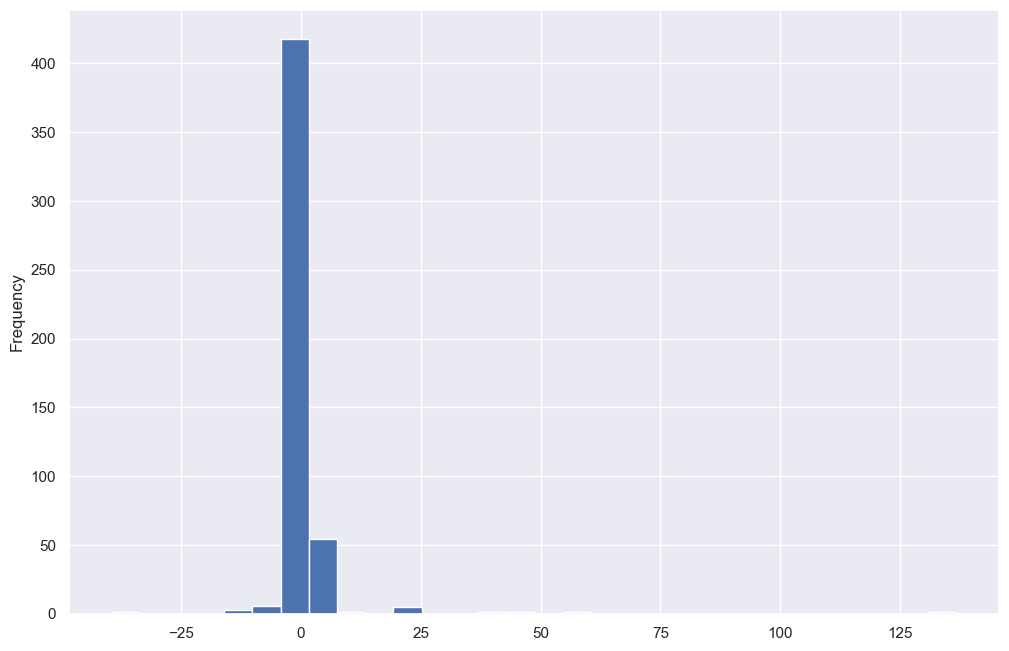

In [472]:
(diff_df['mean_diff']).plot(kind='hist', bins = 30)

<AxesSubplot:ylabel='Density'>

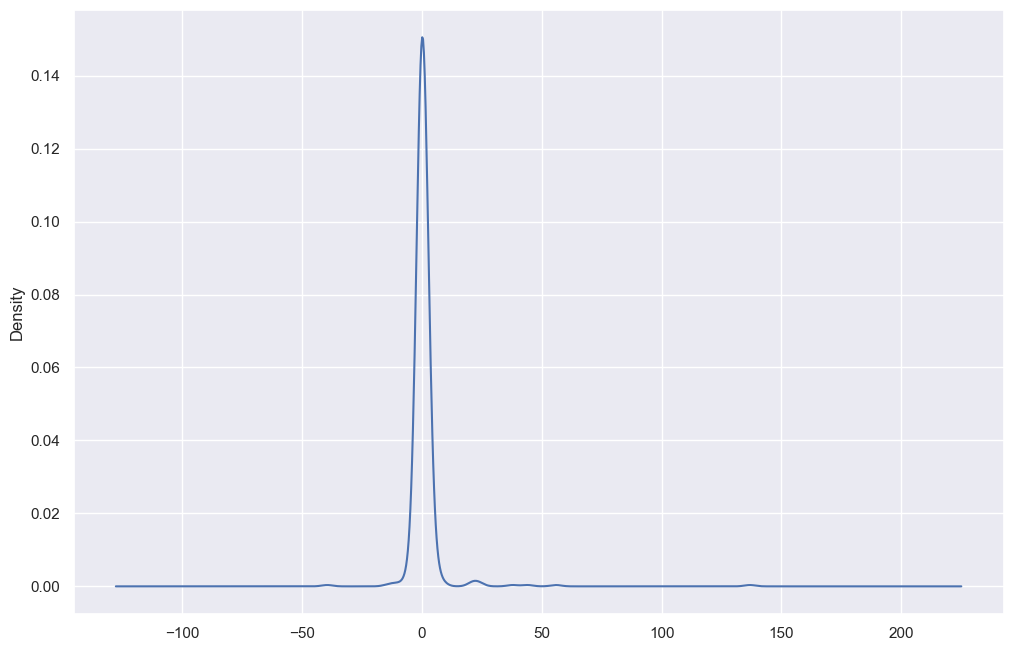

In [473]:
(diff_df['mean_diff']).plot(kind='kde')

/Users/alexandershein/miniconda3/envs/z_cov/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



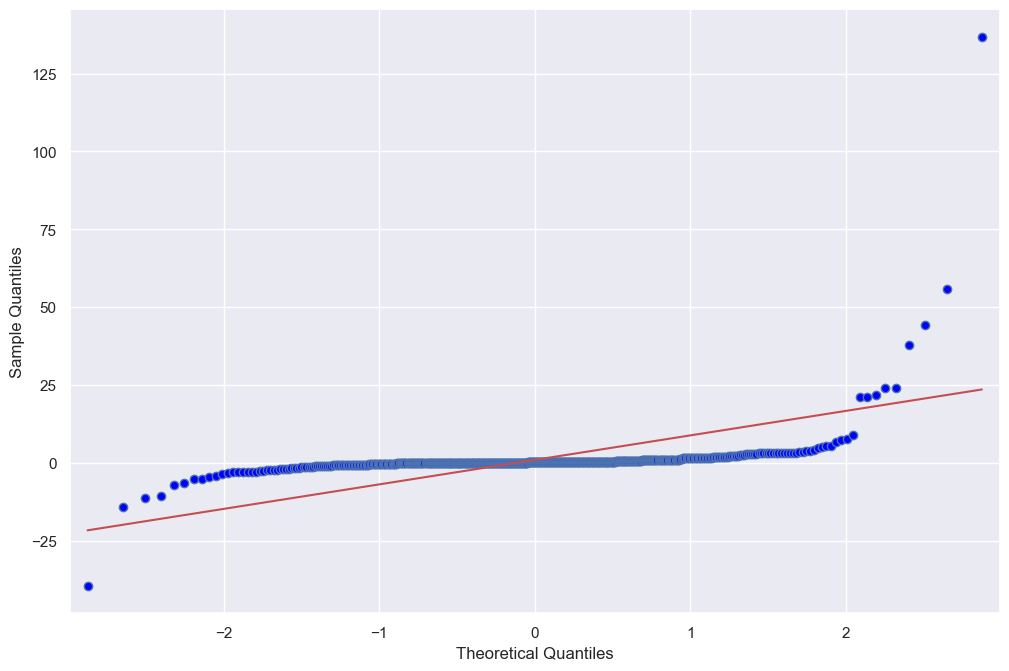

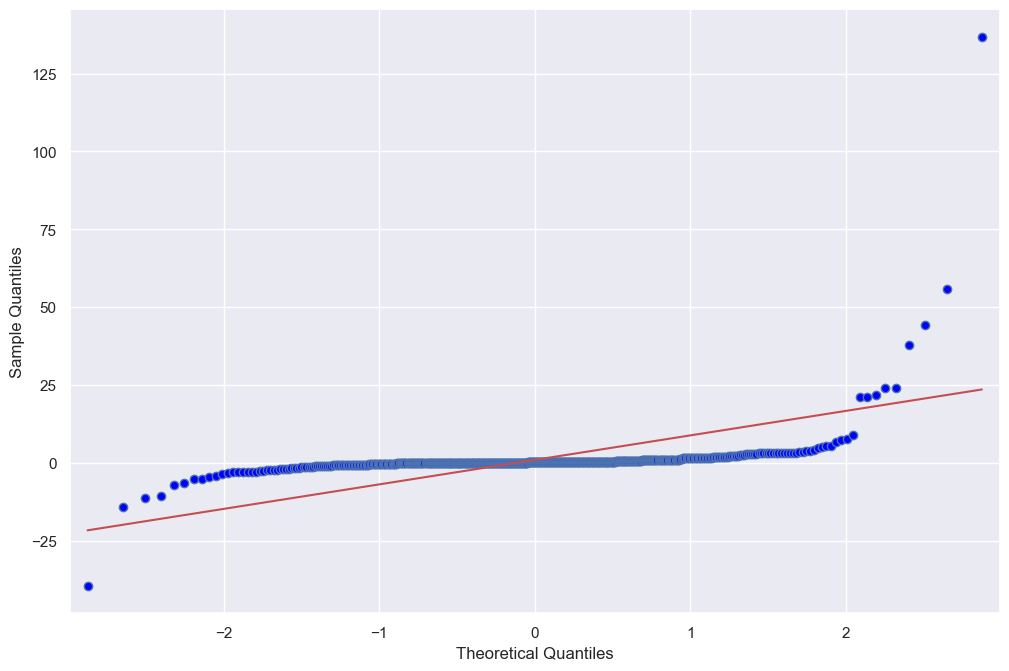

In [476]:
qqplot(diff_df['mean_diff'].dropna(), line='s')

In [470]:
shapiro(diff_df['mean_diff'].dropna())

ShapiroResult(statistic=0.22954559326171875, pvalue=9.499542419504367e-41)

In [449]:
(diff_df['old_mean_score'] - diff_df['new_mean_score']).describe()

count    492.000000
mean       0.934632
std        7.878425
min      -39.500225
25%       -0.057598
50%        0.121533
75%        0.727131
max      136.856521
dtype: float64

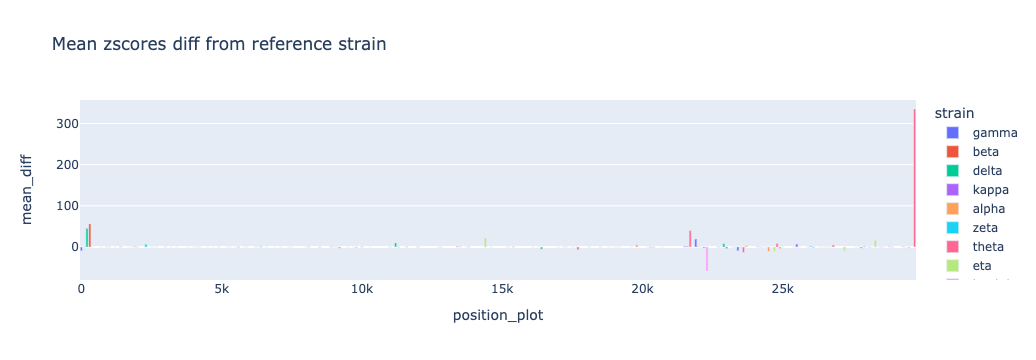

In [450]:
diff_df['mean_diff'] = diff_df['old_mean_score'] - diff_df['new_mean_score']
diff_df['position_plot'] = (diff_df['position'] // 100) * 100
plot_df = diff_df.groupby('position_plot').agg({'mean_diff': 'sum', 'strain': 'first', }).reset_index(drop=False)
# diff_df.plot(kind='bar', x='position_plot', y='mean_diff', title='strain', )
fig = px.bar(plot_df, x="position_plot", y='mean_diff', color='strain', title='Mean zscores diff from reference strain')
fig.show()
fig.write_html("./mean_diff_from_reference.html")

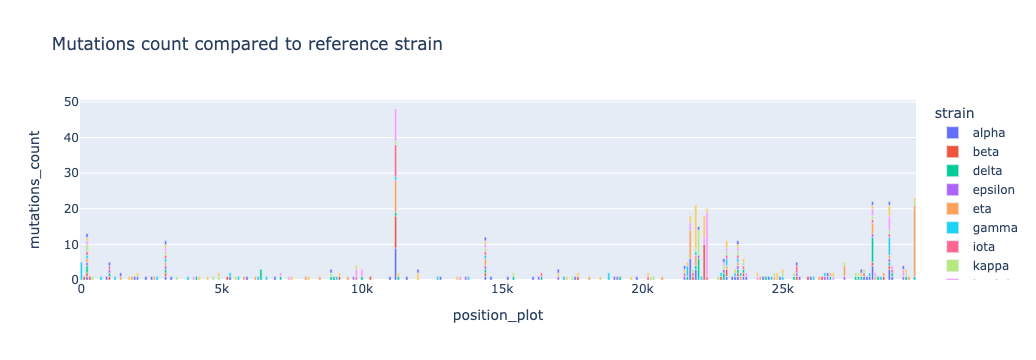

In [459]:
mutations_agg_df = diff_df.groupby(
    ['strain', 'position_plot']
).agg('count').reset_index()[['position_plot','mean_diff', 'strain']].rename(columns={'mean_diff': 'mutations_count'})
fig = px.bar(mutations_agg_df, x="position_plot", y='mutations_count', color='strain', title='Mutations count compared to reference strain')
fig.show()
fig.write_html("./mutations_counts.html")

# Genes annotaion of reference coronavirus

In [37]:
annotations_df = pd.read_csv('all_coronaviruses_genes_annotation.csv')
annotations_df.head()

name    gene locus_tag         db_xref      location gbkey  Start  \
0  NC_004718.3  orf1ab     sars1  GeneID:1489680    265..21485  Gene    265   
1  NC_004718.3       S     sars2  GeneID:1489668  21492..25259  Gene  21492   
2  NC_004718.3     NaN    sars3a  GeneID:1489669  25268..26092  Gene  25268   
3  NC_004718.3     NaN    sars3b  GeneID:1489670  25689..26153  Gene  25689   
4  NC_004718.3       E     sars4  GeneID:1489671  26117..26347  Gene  26117   

     End pseudo  
0  21485    NaN  
1  25259    NaN  
2  26092    NaN  
3  26153    NaN  
4  26347    NaN

In [503]:
analysis_df[analysis_df.strain=='reference']

accession     strain       date acc_date  offset  mean_zscore  \
11  NC_045512.2  reference 2019-12-01        y      73     6.086225   

    median_zscore  
11        0.38445

In [38]:
reference_genes_annotations = annotations_df[annotations_df['name'] == 'NC_045512.2']
reference_genes_annotations

name    gene   locus_tag          db_xref      location gbkey  \
95   NC_045512.2  ORF1ab  GU280_gp01  GeneID:43740578    266..21555  Gene   
96   NC_045512.2       S  GU280_gp02  GeneID:43740568  21563..25384  Gene   
97   NC_045512.2   ORF3a  GU280_gp03  GeneID:43740569  25393..26220  Gene   
98   NC_045512.2       E  GU280_gp04  GeneID:43740570  26245..26472  Gene   
99   NC_045512.2       M  GU280_gp05  GeneID:43740571  26523..27191  Gene   
100  NC_045512.2    ORF6  GU280_gp06  GeneID:43740572  27202..27387  Gene   
101  NC_045512.2   ORF7a  GU280_gp07  GeneID:43740573  27394..27759  Gene   
102  NC_045512.2   ORF7b  GU280_gp08  GeneID:43740574  27756..27887  Gene   
103  NC_045512.2    ORF8  GU280_gp09  GeneID:43740577  27894..28259  Gene   
104  NC_045512.2       N  GU280_gp10  GeneID:43740575  28274..29533  Gene   
105  NC_045512.2   ORF10  GU280_gp11  GeneID:43740576  29558..29674  Gene   

     Start    End pseudo  
95     266  21555    NaN  
96   21563  25384    NaN  
97   25393  26220    NaN  
98   26245  26472    NaN  
99   26523  27191    NaN  
100  27202  27387    NaN  
101  27394  27759    NaN  
102  27756  27887    NaN  
103  27894  28259    NaN  
104  28274  29533    NaN  
105  29558  29674    NaN

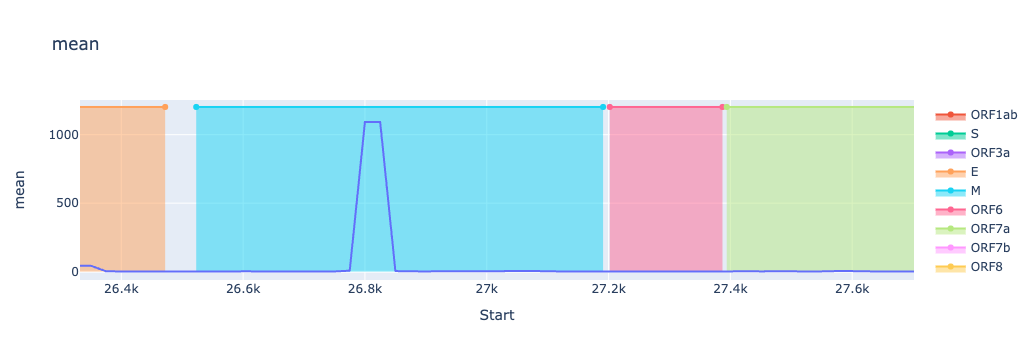

In [518]:
# plot_df = res_df[res_df['strain'] == 'reference'].copy()
plot_df = reference_50_df
METRIC = 'mean'

fig = px.line(plot_df, x="Start", y=METRIC, title=METRIC)
max_score = plot_df[METRIC].max()
MAX_Y_VALUE = max_score
y = 1.1
for _, row in reference_genes_annotations.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.Start, row.End],
            y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
            name=row['gene'],
            fill='tozeroy',
            opacity=0.1
        )
    )

fig.show()

fig.write_html("./reference_annotated_zscores.html")

In [519]:
reference_50_df

strain  Start    End       mean    median  count   scores_sum  \
0     reference      0     50   0.717203  0.271009     49    35.142964   
1     reference     25     75   0.679954  0.271009     65    44.197030   
2     reference     50    100   4.113278  0.495313     63   259.136506   
3     reference     75    125  23.900413  8.941667     63  1505.726039   
4     reference    100    150  22.934790  3.191445     61  1399.022204   
...         ...    ...    ...        ...       ...    ...          ...   
1235  reference  30875  30925   0.000000  0.000000      0     0.000000   
1236  reference  30900  30950   0.000000  0.000000      0     0.000000   
1237  reference  30925  30975   0.000000  0.000000      0     0.000000   
1238  reference  30950  31000   0.000000  0.000000      0     0.000000   
1239  reference  30975  31025   0.000000  0.000000      0     0.000000   

                                                 scores  
0     [0.1882331, 0.4203827, 0.2255438, 0.4671511, 0...  
1     [2.270838, 2.865646, 2.41465, 2.88691, 2.07449...  
2     [0.02398209, 0.06292327, 0.07439108, 0.1926848...  
3     [0.3209553, 0.3904651, 0.451745, 0.2575059, 0....  
4     [0.3851358, 3.040941, 2.989128, 6.987917, 3.85...  
...                                                 ...  
1235                                                 []  
1236                                                 []  
1237                                                 []  
1238                                                 []  
1239                                                 []  

[1240 rows x 8 columns]

In [575]:
tmp_df = reference_50_df.copy()
tmp_df['Chromosome'] = 0
reference_ranges_df = pyranges.PyRanges(tmp_df)


In [576]:
results = []
for _, gene_record in reference_genes_annotations.iterrows():
    intersection_with_gene = reference_ranges_df.intersect(
            pyranges.PyRanges(
            starts=[gene_record.Start], ends=[gene_record.End], chromosomes=[0]
        )  # Chromosomes param added as a workaround for non-chromosome data
    )
    if not intersection_with_gene.empty:
        intersection_with_gene = intersection_with_gene.values()[0]
        intersection_with_gene['gene'] = gene_record['gene']
        results.append(intersection_with_gene)
        
intersected_ref_df = pd.concat(results).drop_duplicates('Start', keep='first').drop(columns=['Chromosome', 'strain', 'scores'])
intersected_ref_df

Start    End       mean     median  count   scores_sum    gene
0     266    275   8.320137   3.014116     61   507.528337  ORF1ab
2     275    325   8.805841   2.747740     65   572.379662  ORF1ab
3     300    350  41.513580  10.799440     64  2656.869149  ORF1ab
4     325    375  36.087546   4.629521     61  2201.340332  ORF1ab
5     350    400  33.087570   4.091466     65  2150.692044  ORF1ab
..    ...    ...        ...        ...    ...          ...     ...
0   29558  29575   4.276641   3.031957     61   260.875103   ORF10
2   29575  29625   2.095667   0.442605     61   127.835657   ORF10
3   29600  29650   2.587115   2.326846     63   162.988235   ORF10
4   29625  29674   1.534621   0.433761     61    93.611909   ORF10
5   29650  29674   1.835261   0.401363     64   117.456688   ORF10

[1182 rows x 7 columns]

In [577]:
intersected_ref_df['gene'].unique()

array(['ORF1ab', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8',
       'N', 'ORF10'], dtype=object)

In [578]:
intersected_ref_df.to_csv('reference_zscores_annotated_by_gene.csv')

In [579]:
intersected_ref_df[
    intersected_ref_df['scores_sum'] >= intersected_ref_df['scores_sum'].quantile(.95)
].to_csv('top_5_percent_reference_zscores_annotated_by_gene.csv')

In [546]:
z_hunt_results['reference']

Start    End  nu-1    nu-2    nu-3   Z-Score          Sequence  \
0          1     17    16  32.059  26.188  0.188233  attaaaggtttatacc   
1          2     18    16  30.200  28.375  0.420383  ttaaaggtttatacct   
2          3     17    14  31.703  27.287  0.225544    taaaggtttatacc   
3          4     18    14  29.878  30.366  0.467151    aaaggtttatacct   
4          5     17    12  31.481  28.602  0.250816      aaggtttatacc   
...      ...    ...   ...     ...     ...       ...               ...   
29898  29899  29913    14  34.855   9.251  0.027928    aaaaaattaaaggt   
29899  29900  29916    16  35.148  20.032  0.021698  aaaaattaaaggttta   
29900  29901  29917    16  33.649  15.281  0.070950  aaaattaaaggtttat   
29901  29902  29918    16  33.586  24.518  0.074107  aaattaaaggtttata   
29902  29903  29919    16  30.707  25.796  0.349235  aattaaaggtttatac   

           Conformation     strain  
0      ASASASASASASASAS  reference  
1      SASASASASASASASA  reference  
2        ASASASASASASAS  reference  
3        SASASASASASASA  reference  
4          ASASASASASAS  reference  
...                 ...        ...  
29898    SASASASASASASA  reference  
29899  ASASASASASASASAS  reference  
29900  SASASASASASASASA  reference  
29901  ASASASASASASASAS  reference  
29902  SASASASASASASASA  reference  

[29903 rows x 9 columns]

In [563]:
tmp_df = z_hunt_results['reference'].copy()
tmp_df['Chromosome'] = 0
zhunt_ranges = pyranges.PyRanges(tmp_df)

results = []
for _, gene_record in reference_genes_annotations.iterrows():
    intersection_with_gene = zhunt_ranges.intersect(
            pyranges.PyRanges(
            starts=[gene_record.Start], ends=[gene_record.End], chromosomes=[0]
        )  # Chromosomes param added as a workaround for non-chromosome data
    )
    if not intersection_with_gene.empty:
        intersection_with_gene = intersection_with_gene.values()[0]
        intersection_with_gene['gene'] = gene_record['gene']
        results.append(intersection_with_gene)
        
zhunt_reference_annotated = pd.concat(results).drop_duplicates('Start', keep='first').drop(columns=['Chromosome', 'strain'])
zhunt_reference_annotated = tmp_df.join(
    zhunt_reference_annotated[['Start', 'gene']],
    how='left', on='Start', rsuffix='_'
).drop(columns=['Start_',])
zhunt_reference_annotated.fillna('-', inplace=True)
zhunt_reference_annotated

Start    End  nu-1    nu-2    nu-3   Z-Score          Sequence  \
0          1     17    16  32.059  26.188  0.188233  attaaaggtttatacc   
1          2     18    16  30.200  28.375  0.420383  ttaaaggtttatacct   
2          3     17    14  31.703  27.287  0.225544    taaaggtttatacc   
3          4     18    14  29.878  30.366  0.467151    aaaggtttatacct   
4          5     17    12  31.481  28.602  0.250816      aaggtttatacc   
...      ...    ...   ...     ...     ...       ...               ...   
29898  29899  29913    14  34.855   9.251  0.027928    aaaaaattaaaggt   
29899  29900  29916    16  35.148  20.032  0.021698  aaaaattaaaggttta   
29900  29901  29917    16  33.649  15.281  0.070950  aaaattaaaggtttat   
29901  29902  29918    16  33.586  24.518  0.074107  aaattaaaggtttata   
29902  29903  29919    16  30.707  25.796  0.349235  aattaaaggtttatac   

           Conformation     strain  Chromosome gene  
0      ASASASASASASASAS  reference           0    -  
1      SASASASASASASASA  reference           0    -  
2        ASASASASASASAS  reference           0    -  
3        SASASASASASASA  reference           0    -  
4          ASASASASASAS  reference           0    -  
...                 ...        ...         ...  ...  
29898    SASASASASASASA  reference           0    -  
29899  ASASASASASASASAS  reference           0    -  
29900  SASASASASASASASA  reference           0    -  
29901  ASASASASASASASAS  reference           0    -  
29902  SASASASASASASASA  reference           0    -  

[37855 rows x 11 columns]

In [564]:
zhunt_reference_annotated.gene.unique()

array(['-', 'ORF1ab', 'S', 'E', 'N', 'ORF10', 'ORF3a', 'ORF6', 'ORF7b',
       'ORF8', 'M', 'ORF7a'], dtype=object)

In [565]:
zhunt_reference_annotated.to_csv('raw_reference_zscores_annotated_by_gene.csv')

In [570]:
zhunt_reference_annotated[
    zhunt_reference_annotated['Z-Score'] >= zhunt_reference_annotated['Z-Score'].quantile(.95)
].to_csv('top_5_percent_raw_reference_zscores_annotated_by_gene.csv')

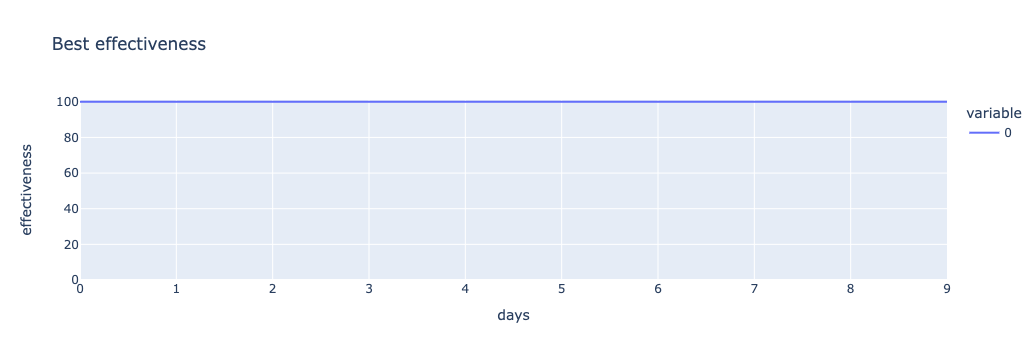

In [599]:
ef = np.zeros(10)
ef[:] = 100

fig = px.line(ef, title='Best effectiveness', range_y=[0, 101], )
fig.update_layout(
    xaxis_title="days",
    yaxis_title="effectiveness",

)
fig.show()

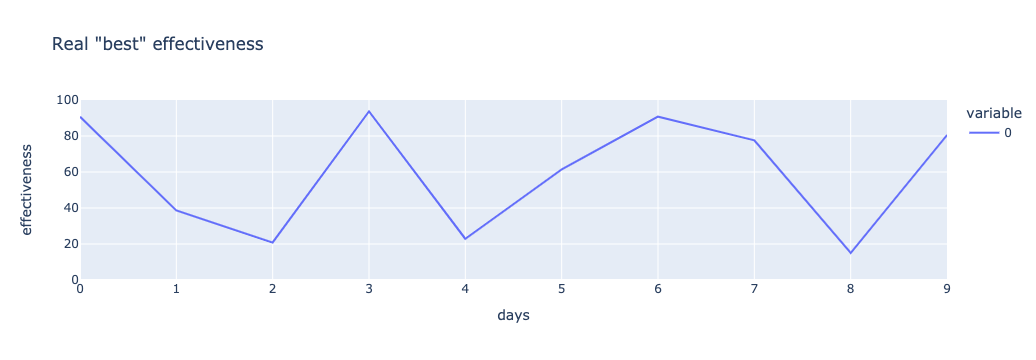

In [600]:
ef_r = np.random.uniform(0, 100, 10)


fig = px.line(ef_r, title='Real "best" effectiveness', range_y=[0, 100])
fig.update_layout(
    xaxis_title="days",
    yaxis_title="effectiveness",

)
fig.show()

# M protein diff between reference and other stems

In [609]:
diff_df

position  position_plot   ref_strain  strain_acc strain ref_base  \
0          75              0  NC_045512.2  MZ169911.1  gamma        T   
1          76              0  NC_045512.2  MZ169911.1  gamma        T   
2          77              0  NC_045512.2  MZ169911.1  gamma        T   
3          78              0  NC_045512.2  MZ169911.1  gamma        A   
4          82              0  NC_045512.2  MZ169911.1  gamma        T   
..        ...            ...          ...         ...    ...      ...   
517     29771          29700  NC_045512.2  MW560924.1    eta        T   
518     29772          29700  NC_045512.2  MW560924.1    eta        G   
519     29773          29700  NC_045512.2  MW560924.1    eta        C   
520     29774          29700  NC_045512.2  MW560924.1    eta        T   
521     29775          29700  NC_045512.2  MW560924.1    eta        A   

    new_base  old_mean_score  new_mean_score  mean_diff  old_median_score  \
0          A        0.245685        1.499158  -1.253473          0.214908   
1          A        0.206859        1.432560  -1.225701          0.202601   
2          A        0.760510        2.507290  -1.746780          0.311375   
3          C        1.872064        4.056529  -2.184465          2.306021   
4          C        4.001981        6.739759  -2.737778          4.026194   
..       ...             ...             ...        ...               ...   
517        -        0.295414        0.236403   0.059011          0.285847   
518        -        0.616128        0.295931   0.320198          0.317268   
519        -        4.541935        5.911505  -1.369570          3.994129   
520        -        0.309460        0.365703  -0.056243          0.329925   
521        -        0.240048        0.361517  -0.121469          0.224803   

     new_median_score  median_diff          pval  statistic  
0            0.497103    -0.282195  1.649882e-06  22.964879  
1            2.047895    -1.845294  4.565532e-07  25.439171  
2            2.509584    -2.198209  1.348278e-05  18.940943  
3            3.719740    -1.413719  2.871242e-03   8.887534  
4            5.345663    -1.319469  1.046304e-01   2.633507  
..                ...          ...           ...        ...  
517          0.247968     0.037879  1.441572e-01   2.133012  
518          0.298175     0.019093  5.774166e-01   0.310430  
519          6.245526    -2.251397  1.182386e-01   2.440500  
520          0.368266    -0.038341  1.294977e-01   2.298515  
521          0.339157    -0.114354  2.694482e-03   9.003601  

[522 rows x 15 columns]

In [617]:
start, end = reference_genes_annotations[reference_genes_annotations['gene'] == 'M'].location.iloc[0].split('..')
start, end = int(start), int(end)

In [619]:
diff_df[(diff_df.position < end) & (diff_df.position > start)]

position  position_plot   ref_strain  strain_acc   strain ref_base  \
383     26526          26500  NC_045512.2  MZ169911.1    gamma        C   
384     26680          26600  NC_045512.2  MW883202.1  epsilon        C   
385     26680          26600  NC_045512.2  MW453103.1     zeta        C   
386     26766          26700  NC_045512.2  MZ359841.1    delta        T   
387     26766          26700  NC_045512.2  MW560924.1      eta        T   
388     26848          26800  NC_045512.2  MZ555270.1    theta        G   
389     26893          26800  NC_045512.2  MZ275289.1   lambda        C   

    new_base  old_mean_score  new_mean_score  mean_diff  old_median_score  \
383        T        0.770420        0.520737   0.249683          0.355650   
384        T        0.523480        0.326368   0.197112          0.328058   
385        T        0.523480        0.326368   0.197112          0.328058   
386        C        0.478609        0.589395  -0.110785          0.241972   
387        C        0.478609        0.589395  -0.110785          0.241972   
388        T       28.829166       24.084763   4.744403         21.656200   
389        T        6.546704        6.330967   0.215737          4.982835   

     new_median_score  median_diff      pval  statistic  
383          0.227097     0.128554  0.170240   1.880827  
384          0.271976     0.056082  0.579833   0.306504  
385          0.271976     0.056082  0.579833   0.306504  
386          0.342284    -0.100312  0.012286   6.269054  
387          0.342284    -0.100312  0.012286   6.269054  
388         20.685100     0.971100  0.308138   1.038642  
389          4.982835     0.000000  0.632528   0.228649

In [622]:
ref_z =z_hunt_results['reference']

ref_z

Start    End  nu-1    nu-2    nu-3   Z-Score          Sequence  \
0          1     17    16  32.059  26.188  0.188233  attaaaggtttatacc   
1          2     18    16  30.200  28.375  0.420383  ttaaaggtttatacct   
2          3     17    14  31.703  27.287  0.225544    taaaggtttatacc   
3          4     18    14  29.878  30.366  0.467151    aaaggtttatacct   
4          5     17    12  31.481  28.602  0.250816      aaggtttatacc   
...      ...    ...   ...     ...     ...       ...               ...   
29898  29899  29913    14  34.855   9.251  0.027928    aaaaaattaaaggt   
29899  29900  29916    16  35.148  20.032  0.021698  aaaaattaaaggttta   
29900  29901  29917    16  33.649  15.281  0.070950  aaaattaaaggtttat   
29901  29902  29918    16  33.586  24.518  0.074107  aaattaaaggtttata   
29902  29903  29919    16  30.707  25.796  0.349235  aattaaaggtttatac   

           Conformation     strain  
0      ASASASASASASASAS  reference  
1      SASASASASASASASA  reference  
2        ASASASASASASAS  reference  
3        SASASASASASASA  reference  
4          ASASASASASAS  reference  
...                 ...        ...  
29898    SASASASASASASA  reference  
29899  ASASASASASASASAS  reference  
29900  SASASASASASASASA  reference  
29901  ASASASASASASASAS  reference  
29902  SASASASASASASASA  reference  

[29903 rows x 9 columns]

In [633]:
ref_z[(ref_z.Start - 26825).abs()< 100].sort_values('Z-Score', ascending=False).iloc[:50

Start    End  nu-1    nu-2    nu-3       Z-Score          Sequence  \
26831  26832  26844    12  19.208  41.778  16271.570000      gcgcgtacgcgt   
26829  26830  26844    14  19.395  43.552  12328.930000    ttgcgcgtacgcgt   
26827  26828  26844    16  19.566  43.689   9602.017000  gtttgcgcgtacgcgt   
26830  26831  26843    12  19.639  41.846   8636.407000      tgcgcgtacgcg   
26828  26829  26843    14  19.828  43.124   6594.469000    tttgcgcgtacgcg   
26826  26827  26843    16  20.001  43.655   5171.499000  tgtttgcgcgtacgcg   
26825  26826  26842    16  20.486  38.057   2664.126000  ctgtttgcgcgtacgc   
26832  26833  26845    12  20.549  37.322   2450.380000      cgcgtacgcgtt   
26833  26834  26846    12  20.860  36.568   1632.822000      gcgtacgcgttc   
26824  26825  26841    16  21.786  35.857    523.491900  actgtttgcgcgtacg   
26823  26824  26840    16  22.607  28.985    208.871300  gactgtttgcgcgtac   
26834  26835  26847    12  22.719  30.062    185.521400      cgtacgcgttcc   
26835  26836  26848    12  23.139  38.039    120.376200      gtacgcgttcca   
26822  26823  26839    16  23.785  24.717     64.584130  agactgtttgcgcgta   
26837  26838  26852    14  24.182  37.899     45.213220    acgcgttccatgtg   
26821  26822  26838    16  24.529  20.638     33.590280  cagactgtttgcgcgt   
26820  26821  26837    16  24.561  20.459     32.697200  tcagactgtttgcgcg   
26839  26840  26852    12  25.189  34.300     19.857320      gcgttccatgtg   
26877  26878  26890    12  25.294   8.158     18.359940      ttctcaacgtgc   
26836  26837  26849    12  25.524  20.893     15.514600      tacgcgttccat   
26883  26884  26898    14  25.739  20.286     13.324970    acgtgccactccat   
26875  26876  26890    14  25.759  10.186     13.140360    tcttctcaacgtgc   
26843  26844  26856    12  26.111  25.890     10.373010      tccatgtggtca   
26873  26874  26890    16  26.307  16.075      9.153062  attcttctcaacgtgc   
26841  26842  26854    12  26.425  24.691      8.502079      gttccatgtggt   
26845  26846  26858    12  26.434  24.199      8.454266      catgtggtcatt   
26838  26839  26851    12  26.672  20.063      7.325029      cgcgttccatgt   
26884  26885  26899    14  26.728  32.038      7.090391    cgtgccactccatg   
26882  26883  26895    12  26.736  31.746      7.055178      aacgtgccactc   
26878  26879  26891    12  26.755  26.148      6.980496      tctcaacgtgcc   
26880  26881  26893    12  26.898  25.376      6.430316      tcaacgtgccac   
26747  26748  26760    12  27.117  30.849      5.698716      atcaccggtgga   
26819  26820  26836    16  27.190  16.014      5.478894  ttcagactgtttgcgc   
26876  26877  26891    14  27.252  23.691      5.302815    cttctcaacgtgcc   
26749  26750  26762    12  27.386  30.736      4.943973      caccggtggaat   
26745  26746  26760    14  27.409  29.334      4.887233    ggatcaccggtgga   
26743  26744  26760    16  27.714  29.530      4.203327  ttggatcaccggtgga   
26892  26893  26905    12  27.778  26.868      4.078523      tccatggcacta   
26874  26875  26891    16  27.839  15.124      3.963564  ttcttctcaacgtgcc   
26780  26781  26793    12  27.936  34.388      3.790385      cttgtaggcttg   
26890  26891  26903    12  27.945  26.895      3.774631      actccatggcac   
26888  26889  26903    14  27.957  30.386      3.754814    ccactccatggcac   
26844  26845  26857    12  28.032  32.581      3.630220      ccatgtggtcat   
26741  26742  26758    16  28.083  26.444      3.547722  aattggatcaccggtg   
26879  26880  26892    12  28.151  31.220      3.445119      ctcaacgtgcca   
26894  26895  26907    12  28.178  24.929      3.404448      catggcactatt   
26782  26783  26795    12  28.187  32.885      3.391945      tgtaggcttgat   
26842  26843  26857    14  28.283  33.079      3.255625    ttccatgtggtcat   
26778  26779  26793    14  28.292  35.126      3.243957    gtcttgtaggcttg   
26886  26887  26903    16  28.321  30.449      3.204448  tgccactccatggcac   

           Conformation     strain  
26831      SASASASASASA  reference  
26829

In [631]:
res_df[(res_df.Start - 26750).abs()< 100].sort_values('scores_sum', ascending=False)

strain  Start    End        mean    median  count    scores_sum  \
536  reference  26800  26900  601.828835  0.454679    111  66803.000630   
536        eta  26800  26900  601.828835  0.454679    111  66803.000630   
536      alpha  26800  26900  601.828835  0.454679    111  66803.000630   
536      delta  26800  26900  601.828835  0.454679    111  66803.000630   
536      gamma  26800  26900  601.828835  0.454679    111  66803.000630   
536      kappa  26800  26900  601.828835  0.454679    111  66803.000630   
536       iota  26800  26900  601.828835  0.454679    111  66803.000630   
536       beta  26800  26900  601.828835  0.454679    111  66803.000630   
536    epsilon  26800  26900  601.828835  0.454679    111  66803.000630   
536       zeta  26800  26900  601.828835  0.454679    111  66803.000630   
536     lambda  26800  26900  601.788164  0.454679    111  66798.486229   
535        eta  26750  26850  585.599586  2.066725    114  66758.352811   
535      delta  26750  26850  585.599586  2.066725    114  66758.352811   
535      alpha  26750  26850  585.580987  2.066725    114  66756.232549   
535  reference  26750  26850  585.580987  2.066725    114  66756.232549   
535       zeta  26750  26850  585.580987  2.066725    114  66756.232549   
535      gamma  26750  26850  585.580987  2.066725    114  66756.232549   
535    epsilon  26750  26850  585.580987  2.066725    114  66756.232549   
535     lambda  26750  26850  585.580987  2.066725    114  66756.232549   
535      kappa  26750  26850  585.580987  2.066725    114  66756.232549   
535       beta  26750  26850  585.580987  2.066725    114  66756.232549   
535       iota  26750  26850  585.580987  2.066725    114  66756.232549   
536      theta  26800  26900  601.097182  0.320554    111  66721.787172   
535      theta  26750  26850  584.868589  0.361231    114  66675.019091   
534        eta  26700  26800    1.494143  0.395859    112    167.344025   
534      delta  26700  26800    1.494143  0.395859    112    167.344025   
534  reference  26700  26800    1.475212  0.357533    112    165.223763   
534      kappa  26700  26800    1.475212  0.357533    112    165.223763   
534    epsilon  26700  26800    1.475212  0.357533    112    165.223763   
534      alpha  26700  26800    1.475212  0.357533    112    165.223763   
534      gamma  26700  26800    1.475212  0.357533    112    165.223763   
534     lambda  26700  26800    1.475212  0.357533    112    165.223763   
534       beta  26700  26800    1.475212  0.357533    112    165.223763   
534       iota  26700  26800    1.475212  0.357533    112    165.223763   
534       zeta  26700  26800    1.475212  0.357533    112    165.223763   
534      theta  26700  26800    1.475212  0.357533    112    165.223763   

                                                scores  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
536  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
535  [0.03419691, 0.07128518, 0.036

In [645]:
''.join(aligned_sequences_df.loc['NC_045512.2', 26800:26900].tolist())

'CAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCA'

In [635]:
aligned_sequences_df.index

Index(['MZ169911.1', 'MZ555270.1', 'OD920331.1', 'MZ359841.1', 'MZ702637.1',
       'MZ275289.1', 'MW560924.1', 'MW598419.1', 'MW883202.1', 'MW453103.1',
       'MZ681419.1', 'NC_045512.2'],
      dtype='object')

In [647]:
reference_genes_annotations

name    gene   locus_tag          db_xref      location gbkey  \
95   NC_045512.2  ORF1ab  GU280_gp01  GeneID:43740578    266..21555  Gene   
96   NC_045512.2       S  GU280_gp02  GeneID:43740568  21563..25384  Gene   
97   NC_045512.2   ORF3a  GU280_gp03  GeneID:43740569  25393..26220  Gene   
98   NC_045512.2       E  GU280_gp04  GeneID:43740570  26245..26472  Gene   
99   NC_045512.2       M  GU280_gp05  GeneID:43740571  26523..27191  Gene   
100  NC_045512.2    ORF6  GU280_gp06  GeneID:43740572  27202..27387  Gene   
101  NC_045512.2   ORF7a  GU280_gp07  GeneID:43740573  27394..27759  Gene   
102  NC_045512.2   ORF7b  GU280_gp08  GeneID:43740574  27756..27887  Gene   
103  NC_045512.2    ORF8  GU280_gp09  GeneID:43740577  27894..28259  Gene   
104  NC_045512.2       N  GU280_gp10  GeneID:43740575  28274..29533  Gene   
105  NC_045512.2   ORF10  GU280_gp11  GeneID:43740576  29558..29674  Gene   

     Start    End pseudo  
95     266  21555    NaN  
96   21563  25384    NaN  
97   25393  26220    NaN  
98   26245  26472    NaN  
99   26523  27191    NaN  
100  27202  27387    NaN  
101  27394  27759    NaN  
102  27756  27887    NaN  
103  27894  28259    NaN  
104  28274  29533    NaN  
105  29558  29674    NaN

In [655]:
z_hunt_results.keys()

dict_keys(['epsilon', 'zeta', 'eta', 'iota', 'beta', 'lambda', 'theta', 'gamma', 'alpha', 'delta', 'kappa', 'reference', 'sars2003'])

# Compare SARS CoV Vs SARS CoV 2 M proteins zscores

In [661]:
sars_cov_m_bounds = [26398, 27063]

In [668]:
reference_bounds = [26523, 27191]

In [669]:
res_df[
    (res_df['strain'] == 'sars2003') &
    (res_df.Start < sars_cov_m_bounds[1]) &
    (res_df.Start >= sars_cov_m_bounds[0])
]

strain  Start    End       mean    median  count  scores_sum  \
1056  sars2003  26400  26450   0.577459  0.215105     63   36.379896   
1057  sars2003  26425  26475   0.177372  0.174685     61   10.819694   
1058  sars2003  26450  26500   0.194690  0.181055     63   12.265462   
1059  sars2003  26475  26525   0.593080  0.259465     61   36.177873   
1060  sars2003  26500  26550   1.068368  0.349134     62   66.238825   
1061  sars2003  26525  26575   1.784632  2.161192     64  114.216470   
1062  sars2003  26550  26600   2.554855  2.526040     61  155.846171   
1063  sars2003  26575  26625   2.825698  2.640658     63  178.018983   
1064  sars2003  26600  26650   2.165739  2.364119     62  134.275805   
1065  sars2003  26625  26675   1.758960  2.047520     63  110.814508   
1066  sars2003  26650  26700   1.900309  0.403790     63  119.719488   
1067  sars2003  26675  26725   8.226401  0.463816     62  510.036832   
1068  sars2003  26700  26750   8.488255  0.493523     61  517.783533   
1069  sars2003  26725  26775   2.057512  0.493523     61  125.508258   
1070  sars2003  26750  26800   2.844178  2.431579     61  173.494854   
1071  sars2003  26775  26825   2.158525  2.277989     62  133.828525   
1072  sars2003  26800  26850   4.205122  2.997176     61  256.512412   
1073  sars2003  26825  26875   4.850754  4.087930     61  295.895995   
1074  sars2003  26850  26900   3.418670  2.479628     64  218.794909   
1075  sars2003  26875  26925   2.644106  2.097057     61  161.290439   
1076  sars2003  26900  26950  11.330906  3.542006     63  713.847062   
1077  sars2003  26925  26975  12.320525  3.099611     61  751.552030   
1078  sars2003  26950  27000  12.289622  2.518268     62  761.956544   
1079  sars2003  26975  27025   4.249065  2.257220     61  259.192975   
1080  sars2003  27000  27050   2.461988  0.224938     61  150.181286   
1081  sars2003  27025  27075   2.496459  0.416817     64  159.773399   
1082  sars2003  27050  27100   0.554537  0.303958     61   33.826769   

                                                 scores  
1056  [0.3086042, 0.2097013, 0.4359693, 0.2545454, 2...  
1057  [0.1159138, 0.155261, 0.2680436, 0.0834992, 0....  
1058  [0.1162646, 0.1429668, 0.2021582, 0.3726732, 0...  
1059  [0.2481098, 0.05847403, 0.1211645, 0.09056919,...  
1060  [0.2130772, 0.214384, 0.2823478, 0.2064851, 0....  
1061  [0.2203221, 0.4862741, 0.2713062, 2.167228, 0....  
1062  [0.03119824, 0.3741178, 0.1175868, 0.4009244, ...  
1063  [2.65021, 0.4802815, 2.640658, 2.177316, 0.349...  
1064  [5.378548, 6.086469, 6.445852, 2.366573, 2.569...  
1065  [0.2192596, 0.3512297, 0.4697391, 3.464354, 2....  
1066  [0.2718271, 0.4344676, 0.4585054, 2.01212, 2.0...  
1067  [0.2613591, 2.393907, 2.147314, 0.4729535, 0.1...  
1068  [0.2004554, 0.4932544, 0.2491052, 2.104154, 2....  
1069  [0.4929859, 0.376927, 2.23574, 0.4236314, 2.22...  
1070  [0.2432353, 0.4681326, 0.2375798, 0.275562, 0....  
1071  [2.446107, 2.608848, 3.472648, 2.413122, 2.905...  
1072  [10.77878, 2.289696, 2.697003, 0.0967606, 2.23...  
1073  [0.4877057, 0.3658996, 3.478194, 0.42495, 3.65...  
1074  [3.350485, 4.050491, 7.578252, 6.558296, 9.003...  
1075  [2.023785, 2.440901, 0.2871452, 0.4551236, 0.1...  
1076  [0.1008592, 0.05261639, 0.1889605, 0.1831303, ...  
1077  [2.605354, 3.977106, 0.2343316, 3.099611, 0.21...  
1078  [4.123491, 12.38126, 5.852011, 12.94801, 8.809...  
1079  [0.2986424, 0.3064742, 2.247328, 3.765225, 7.6...  
1080  [0.1669393, 0.1642594, 0.2745137, 0.3613508, 0...  
1081  [4.584741, 4.478144, 5.280721, 7.814328, 6.205...  
1082  [0.05390613, 0.04772288, 0.1322584, 0.144288, ...

In [670]:
res_df[
    (res_df['strain'] == 'reference') &
    (res_df.Start < reference_bounds[1]) &
    (res_df.Start >= reference_bounds[0])
]

strain  Start    End         mean    median  count    scores_sum  \
1061  reference  26525  26575     0.382168  0.199200     65     24.840914   
1062  reference  26550  26600     0.182147  0.144135     61     11.110967   
1063  reference  26575  26625     0.759737  0.199200     63     47.863430   
1064  reference  26600  26650     2.010608  0.383426     62    124.657669   
1065  reference  26625  26675     1.588694  0.379401     61     96.910359   
1066  reference  26650  26700     0.444024  0.294220     61     27.085493   
1067  reference  26675  26725     1.207879  0.294220     61     73.680624   
1068  reference  26700  26750     1.544775  0.353481     62     95.776065   
1069  reference  26725  26775     1.547405  0.369451     63     97.486516   
1070  reference  26750  26800     1.464846  0.407186     64     93.750168   
1071  reference  26775  26825     6.678277  0.354147     61    407.374904   
1072  reference  26800  26850  1093.048387  2.476690     61  66675.951578   
1073  reference  26825  26875  1093.020559  2.335463     61  66674.254085   
1074  reference  26850  26900     3.896218  0.455124     62    241.565527   
1075  reference  26875  26925     2.235142  0.378442     62    138.578820   
1076  reference  26900  26950     1.335630  0.447502     62     82.809088   
1077  reference  26925  26975     2.837836  2.381413     61    173.107987   
1078  reference  26950  27000     2.806585  2.381413     65    182.428027   
1079  reference  26975  27025     1.838425  0.493165     61    112.143955   
1080  reference  27000  27050     2.641141  0.480149     62    163.750751   
1081  reference  27025  27075     3.523097  0.345174     61    214.908928   
1082  reference  27050  27100     4.178180  2.605354     61    254.868956   
1083  reference  27075  27125     4.577118  2.498716     65    297.512641   
1084  reference  27100  27150     2.639182  0.420558     61    160.990098   
1085  reference  27125  27175     1.083127  0.238880     62     67.153851   
1086  reference  27150  27200     1.541928  0.338829     63     97.141470   
1087  reference  27175  27225     1.226644  0.264654     61     74.825289   

                                                 scores  
1061  [0.358329, 0.187447, 0.4505899, 0.2512452, 2.1...  
1062  [0.418103, 0.1059428, 0.04359325, 0.1115497, 0...  
1063  [0.1127905, 0.2800014, 0.1406993, 0.3294372, 0...  
1064  [0.240643, 0.08040789, 0.1459768, 0.0832239, 0...  
1065  [0.3064742, 0.1100651, 0.2718271, 0.1166602, 0...  
1066  [2.358237, 0.4959398, 0.3794011, 0.2814384, 0....  
1067  [0.02005404, 0.009773677, 0.01715699, 0.000485...  
1068  [0.2673787, 0.2942195, 0.09034972, 0.2491764, ...  
1069  [4.984398, 6.459208, 8.099025, 5.881377, 5.378...  
1070  [0.03419691, 0.07128518, 0.03645001, 0.1092232...  
1071  [0.1823576, 0.2673787, 0.2255438, 0.3648028, 3...  
1072  [0.3205536, 2.506315, 0.3544808, 2.513954, 2.3...  
1073  [0.1286422, 0.1248181, 0.1394004, 0.1074702, 0...  
1074  [45.21322, 7.325029, 19.85732, 2.335463, 8.502...  
1075  [0.1710688, 0.2075753, 0.04403038, 0.2693018, ...  
1076  [3.204448, 3.754814, 0.2952255, 3.774631, 0.38...  
1077  [2.00742, 0.1840842, 0.4118045, 0.4238951, 0.1...  
1078  [0.3133606, 3.031957, 0.3356321, 3.226579, 0.3...  
1079  [2.265827, 0.2407128, 0.4418968, 0.3623599, 2....  
1080  [3.377743, 3.810483, 0.4073567, 4.51328, 0.364...  
1081  [0.193669, 0.06303432, 0.02657477, 0.01504623,...  
1082  [11.31454, 8.945081, 10.1132, 2.605354, 3.9771...  
1083  [0.2861521, 2.498716, 0.3600906, 3.098837, 0.4...  
1084  [0.1706701, 0.3487363, 0.4205581, 0.3281389, 0...  
1085  [0.4234557, 0.3223224, 0.4692035, 0.2258135, 0...  
1086  [2.519984, 2.935172, 3.438744, 5.622273, 2.535...  
1087  [0.04683765, 0.07907676, 0.06261868, 0.0539061...

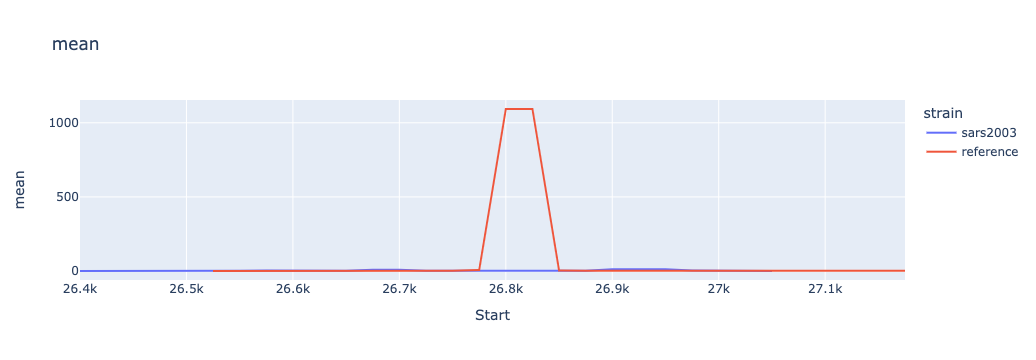

In [674]:
ref_and_2003_df = pd.concat([res_df[
    (res_df['strain'] == 'sars2003') &
    (res_df.Start < sars_cov_m_bounds[1]) &
    (res_df.Start >= sars_cov_m_bounds[0])
],
res_df[
    (res_df['strain'] == 'reference') &
    (res_df.Start < reference_bounds[1]) &
    (res_df.Start >= reference_bounds[0])
],]
                           )
ref_and_2003_df
# METRIC = 'scores_sum'
METRIC = 'mean'

fig = px.line(ref_and_2003_df, x="Start", y=METRIC, title=METRIC, color='strain')
fig.show()

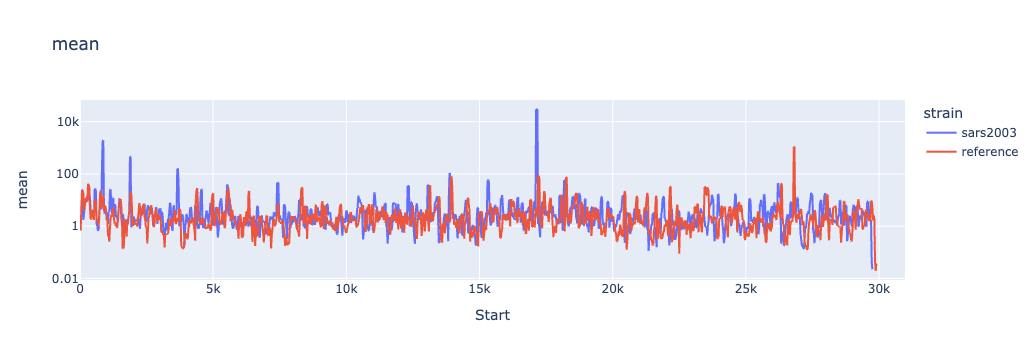

In [679]:
ref_and_2003_df = pd.concat([res_df[
    (res_df['strain'] == 'sars2003')
],
res_df[
    (res_df['strain'] == 'reference')
],]
                           )

# METRIC = 'scores_sum'
METRIC = 'mean'

fig = px.line(ref_and_2003_df, x="Start", y=METRIC, title=METRIC, color='strain', log_y=True)
fig.show()
fig.write_html("./log_y_sars2003_sarscov2.html")

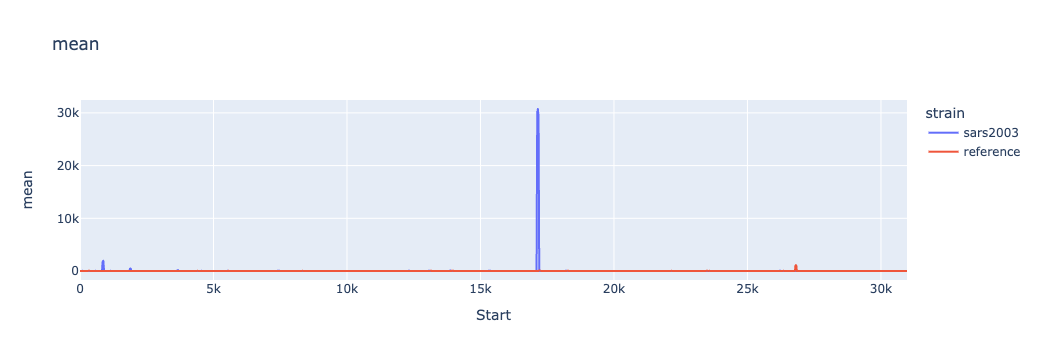

In [680]:
ref_and_2003_df = pd.concat([res_df[
    (res_df['strain'] == 'sars2003')
],
res_df[
    (res_df['strain'] == 'reference')
],]
                           )

# METRIC = 'scores_sum'
METRIC = 'mean'

fig = px.line(ref_and_2003_df, x="Start", y=METRIC, title=METRIC, color='strain')
fig.show()
fig.write_html("./sars2003_sarscov2.html")

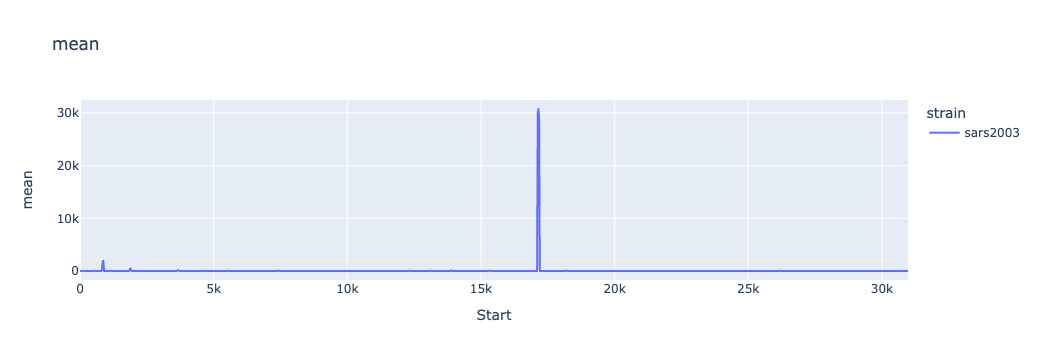

In [676]:
METRIC = 'mean'

fig = px.line(res_df[
    (res_df['strain'] == 'sars2003')
], x="Start", y=METRIC, title=METRIC, color='strain')
fig.show()

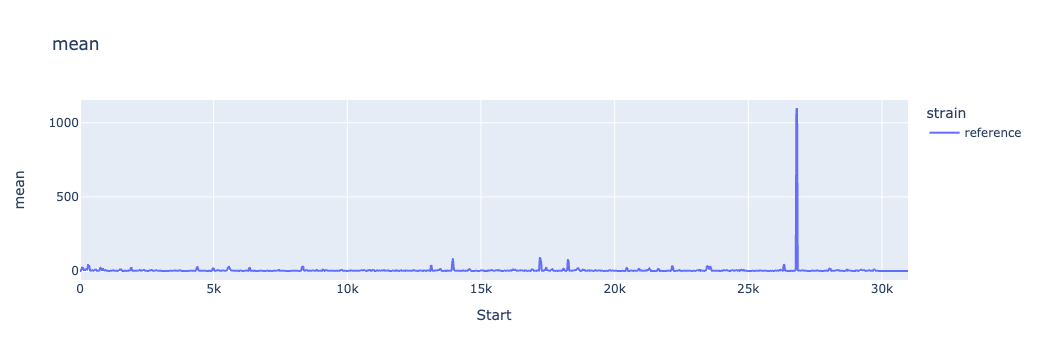

In [677]:
METRIC = 'mean'

fig = px.line(res_df[
    (res_df['strain'] == 'reference')
], x="Start", y=METRIC, title=METRIC, color='strain')
fig.show()

In [ ]:


# z_hunt_res = alanrun(''.join(tmp_fasta.readlines()[1:]).replace('\n', ''),)

In [708]:
# SeqIO.read('others/InfluenzaA_H1B1_2009_california.fna', format='fna')

h1_seq = ''
for record in SeqIO.parse("others/InfluenzaA_H1B1_2009_california.fna", "fasta"):
    h1_seq+=str(record.seq)

h3_seq = ''
for record in SeqIO.parse("others/InfluenzaA_H3N2_2004_New York.fna", "fasta"):
    h3_seq+=str(record.seq)

In [709]:
z_hunt_res_h1 = alanrun(h1_seq)
z_hunt_res_h3 = alanrun(h3_seq)

dinucleotides 8
min/max 6 8
min/max 6 8
operating on /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpdkg2bb5e
calculating zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpdkg2bb5e
inputting sequence
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpdkg2bb5e.Z-SCORE

 run time=0 sec
use min/max 6 8
analyzing_zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpdkg2bb5e.Z-SCORE
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmpdkg2bb5e
inputting sequence
dinucleotides 8
min/max 6 8
min/max 6 8
operating on /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp988qkgzw
calculating zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp988qkgzw
inputting sequence
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp988qkgzw.Z-SCORE

 run time=1 sec
use min/max 6 8
analyzing_zscore
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp988qkgzw.Z-SCORE
opening /var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/tmp98

In [715]:

influenza_df = pd.concat(
    [
        process_sequence_zscores('h1', z_hunt_res_h1, bin_ranges),
        process_sequence_zscores('h3', z_hunt_res_h3, bin_ranges)
    ]
)
influenza_df

strain  Start    End       mean    median  count   scores_sum  \
0        h1      0     50  23.206569  0.223058     49  1137.121871   
1        h1     25     75  18.505985  2.426047     64  1184.383065   
2        h1     50    100  19.122941  2.952982     65  1242.991168   
3        h1     75    125   3.639876  2.765007     65   236.591966   
4        h1    100    150   4.172273  2.167438     62   258.680930   
...     ...    ...    ...        ...       ...    ...          ...   
1235     h3  30875  30925   0.000000  0.000000      0     0.000000   
1236     h3  30900  30950   0.000000  0.000000      0     0.000000   
1237     h3  30925  30975   0.000000  0.000000      0     0.000000   
1238     h3  30950  31000   0.000000  0.000000      0     0.000000   
1239     h3  30975  31025   0.000000  0.000000      0     0.000000   

                                                 scores  
0     [0.03280872, 0.1230275, 0.05055249, 0.05322167...  
1     [0.01709036, 0.05625503, 0.02534328, 0.0818576...  
2     [31.70353, 31.75157, 183.9764, 30.34699, 174.8...  
3     [0.2980976, 0.2581581, 0.3927924, 2.778561, 2....  
4     [0.1163525, 4.536466, 2.488467, 8.840001, 3.09...  
...                                                 ...  
1235                                                 []  
1236                                                 []  
1237                                                 []  
1238                                                 []  
1239                                                 []  

[2480 rows x 8 columns]

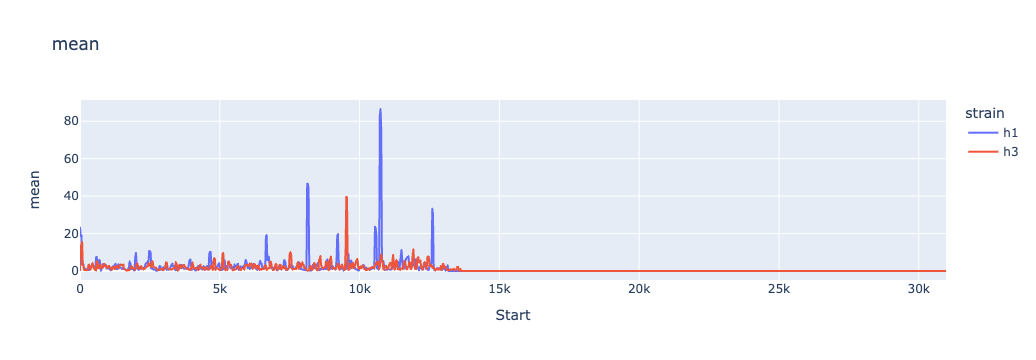

In [716]:
METRIC = 'mean'

fig = px.line(influenza_df, x="Start", y=METRIC, color='strain', title=METRIC)
max_score = res_df[METRIC].max()

fig.show()

# Find and compare significant ZDNA genome location

In [46]:
Z_SCORE_THRESHOLD = 150


combined_zhunt_results = []
for strain in z_hunt_results:
    if strain not in exclude_list:
        t_df = z_hunt_results[strain]
        t_df = t_df[t_df['Z-Score'] >= Z_SCORE_THRESHOLD]
        t_df['strain'] = strain
        combined_zhunt_results.append(
            t_df
        )
combined_zhunt_df = pd.concat(combined_zhunt_results)
del combined_zhunt_results

/var/folders/92/ml61nt355nb1nv82hmrrmz300000gn/T/ipykernel_6311/1342781556.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
bin_borders_r = get_bins_borders(100, 31000)
bin_ranges = list(zip(bin_borders_r[:-2], bin_borders_r[2:]))
def process_intersect_zdna_with_ranges(zscores_df, bin_ranges):
    bins_stats = []
    
    tmp_df = zscores_df.copy()
    tmp_df['Chromosome'] = 0
    for strain, group_df in tmp_df.groupby('strain'):
        ranges = pyranges.PyRanges(tmp_df)
        for range_ in bin_ranges:
            intersections_df = ranges.intersect(
                pyranges.PyRanges(
                    starts=[range_[0]], ends=[range_[1]], chromosomes=[0]
                )  # Chromosomes param added as a workaround for non-chromosome data
            ).df
            if intersections_df.empty:
                bins_stats.append(
                    dict(
                        strain=strain,
                        Start=range_[0],
                        End=range_[1],
                        count=0,
                    )
                )
                continue
            bins_stats.append(
                dict(
                    strain=strain,
                    Start=range_[0],
                    End=range_[1],
                    count=intersections_df.shape[0]
                )
            )
    result_df = pd.DataFrame(bins_stats)
    return result_df

bins_zdf = process_intersect_zdna_with_ranges(combined_zhunt_df, bin_ranges)

In [48]:
agg_b_zdf = bins_zdf.groupby(
    ['Start', 'strain']
).agg({'count': lambda series: 1 if series.sum() > 0 else 0}).reset_index(drop=False)

In [49]:
agg_b_zdf.describe()

Start        count
count   7440.000000  7440.000000
mean   15475.000000     0.085484
std     8949.518999     0.279619
min        0.000000     0.000000
25%     7737.500000     0.000000
50%    15475.000000     0.000000
75%    23212.500000     0.000000
max    30950.000000     1.000000

In [50]:
agg_b_zdf[agg_b_zdf['count'] > 0]

Start     strain  count
0         0      alpha      1
1         0       beta      1
2         0      delta      1
3         0    epsilon      1
4         0        eta      1
...     ...        ...    ...
6739  28050      kappa      1
6740  28050     lambda      1
6741  28050  reference      1
6742  28050      theta      1
6743  28050       zeta      1

[636 rows x 3 columns]

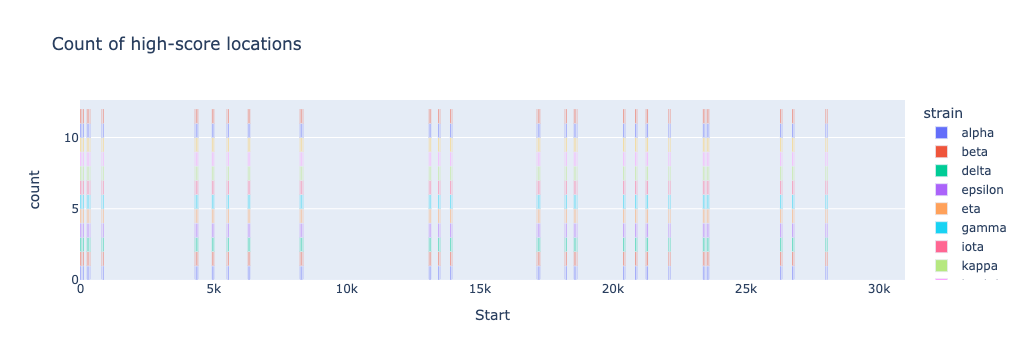

In [53]:
METRIC = 'tmp'

fig = px.bar(agg_b_zdf, x="Start", y="count", color="strain", title="Count of high-score locations")

MAX_Y_VALUE = 11
y = 1.1
# for _, row in reference_genes_annotations.iterrows():
#     fig.add_trace(
#         go.Scatter(
#             x=[row.Start, row.End],
#             y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
#             name=row['gene'],
#             fill='tozeroy',
#             opacity=0.05
#         )
#     )

fig.show()